Loading RS file...
Available contour types (59): ['zRingPTV_Mid01', 'zRingPTV_Mid00', 'CouchSurface', 'CouchInterior', 'zRingPTV_Low', 'zRingPTV_High', 'zOptPTV_Mid01', 'zOptPTV_Mid00', 'zOptPTV_Low', 'zOptPTV_High', 'z_Planveri', 'z_Avoid', 'z_Artifact', 'Trachea', 'SpinalCord_PRV', 'SpinalCord', 'Retina_R', 'Retina_L', 'PTV_Mid01', 'PTV_Mid00', 'PTV_Low', 'PTV_High', 'PTV_all', 'Pituitary', 'Parotid_R', 'Parotid_L', 'Oral_Cavity-PTV', 'Oral_Cavity', 'OpticNrv_R', 'OpticNrv_L', 'OpticChiasm', 'Musc_Constrict', 'Mandible', 'Lungs', 'Lens_R', 'Lens_L', 'Heart', 'GTV', 'Glottis', 'Glnd_Submand_R', 'Glnd_Submand_L', 'Glnd_Lacrimal_R', 'Glnd_Lacrimal_L', 'Eye_R', 'Eye_L', 'External', 'Esophagus', 'CTV_Mid01', 'CTV_Mid00', 'CTV_Low', 'CTV_High', 'Cochlea_R', 'Cochlea_L', 'Brainstem', 'Brain', 'Bone', 'A_Carotid_R', 'A_Carotid_L', 'Dose 75[%]']
Visualizing contours in 2D...
Found 196 unique Z positions


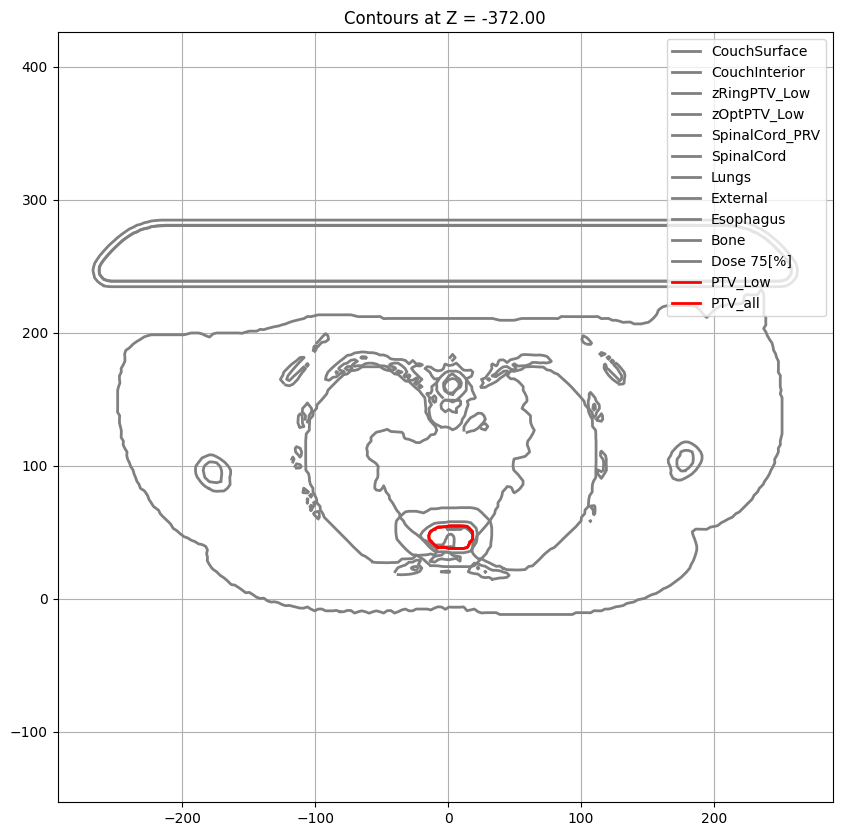

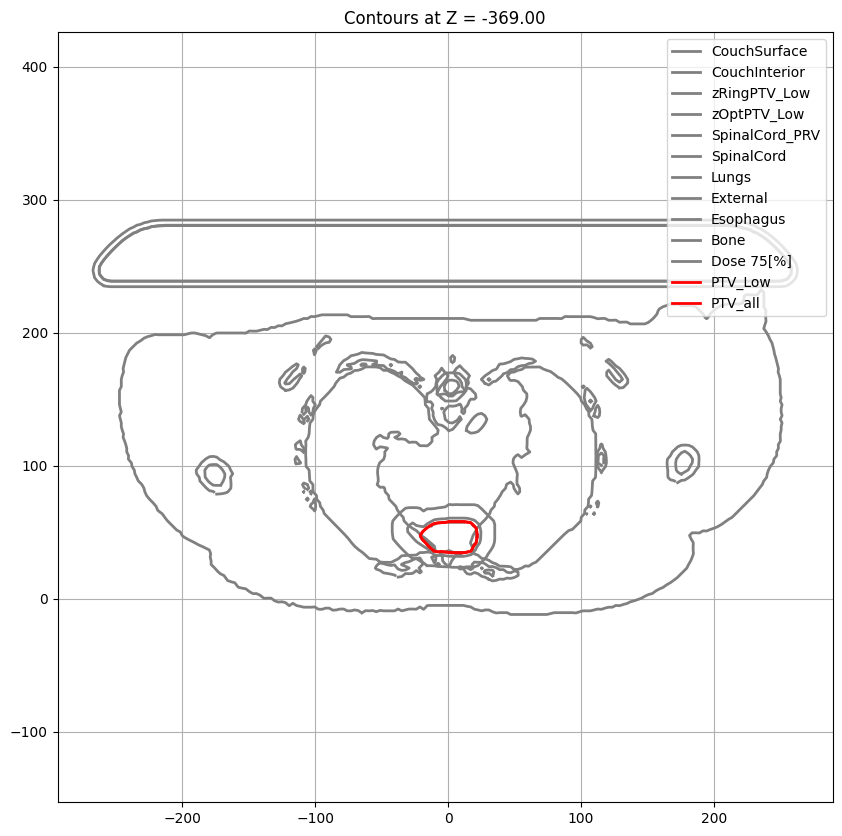

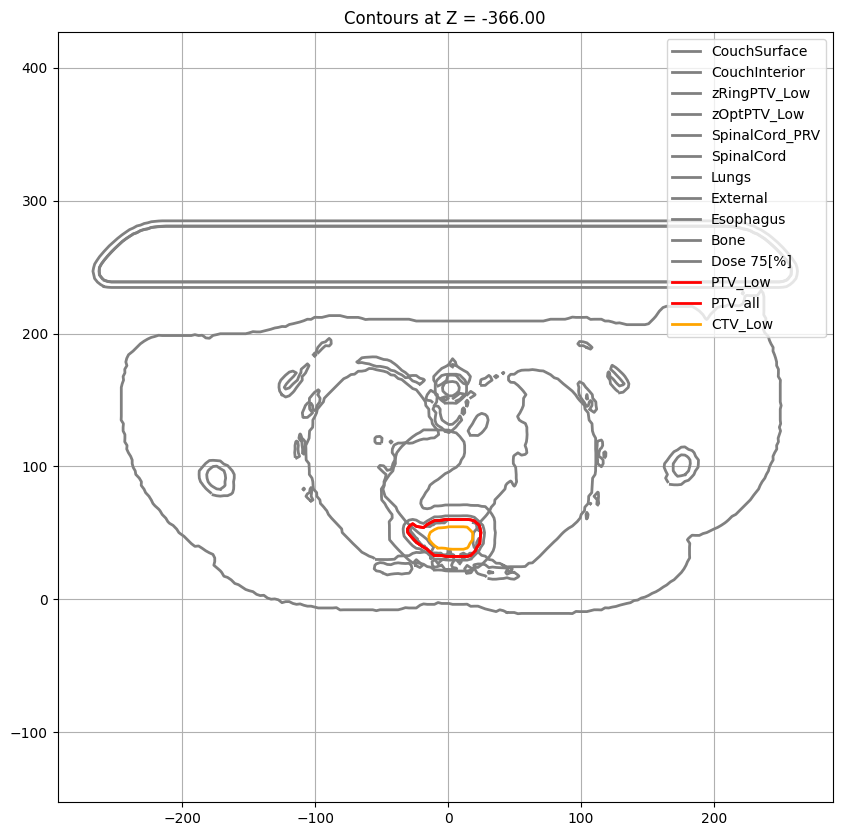

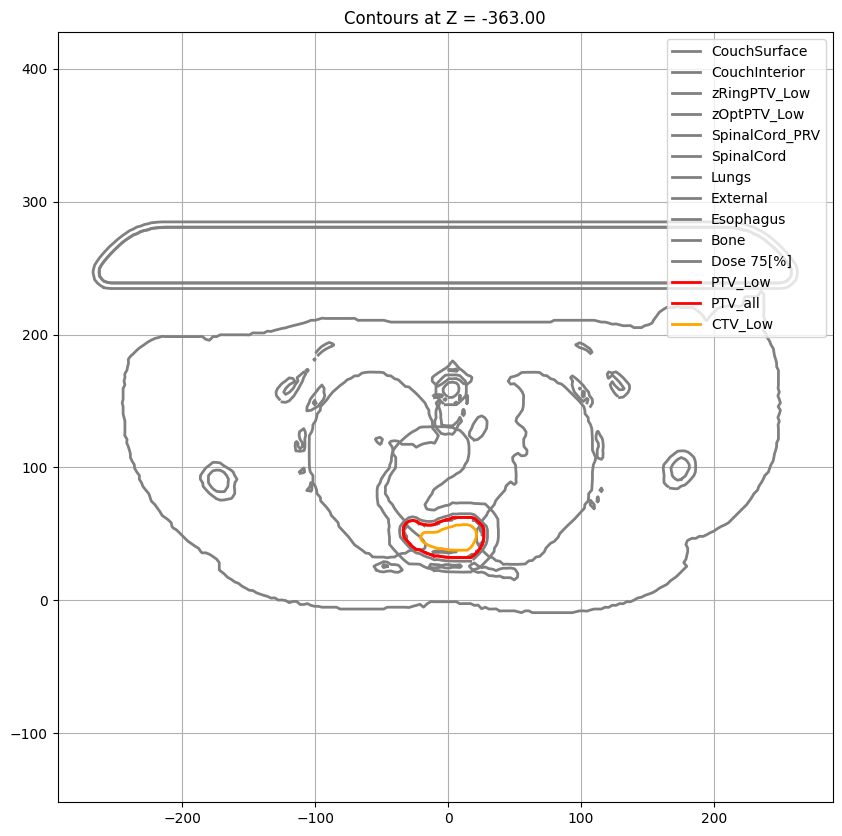

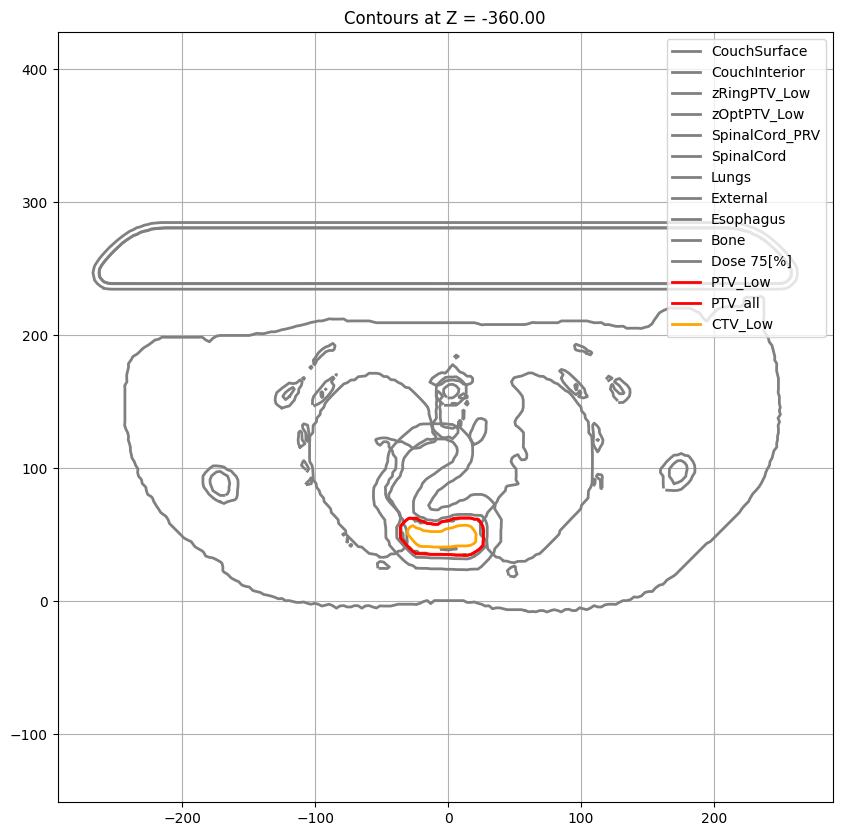

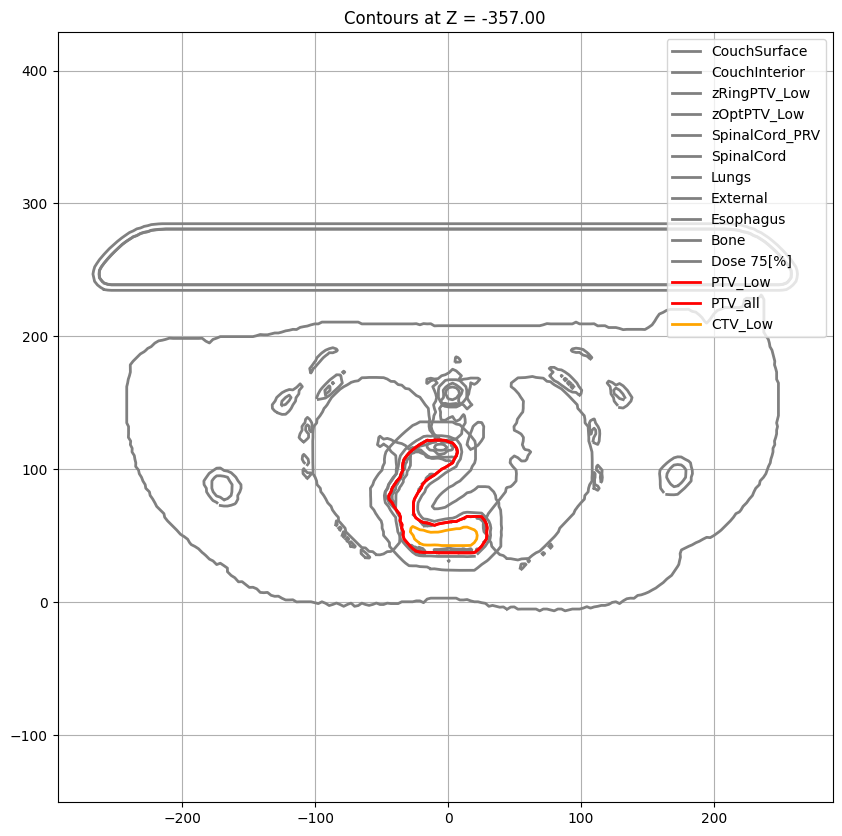

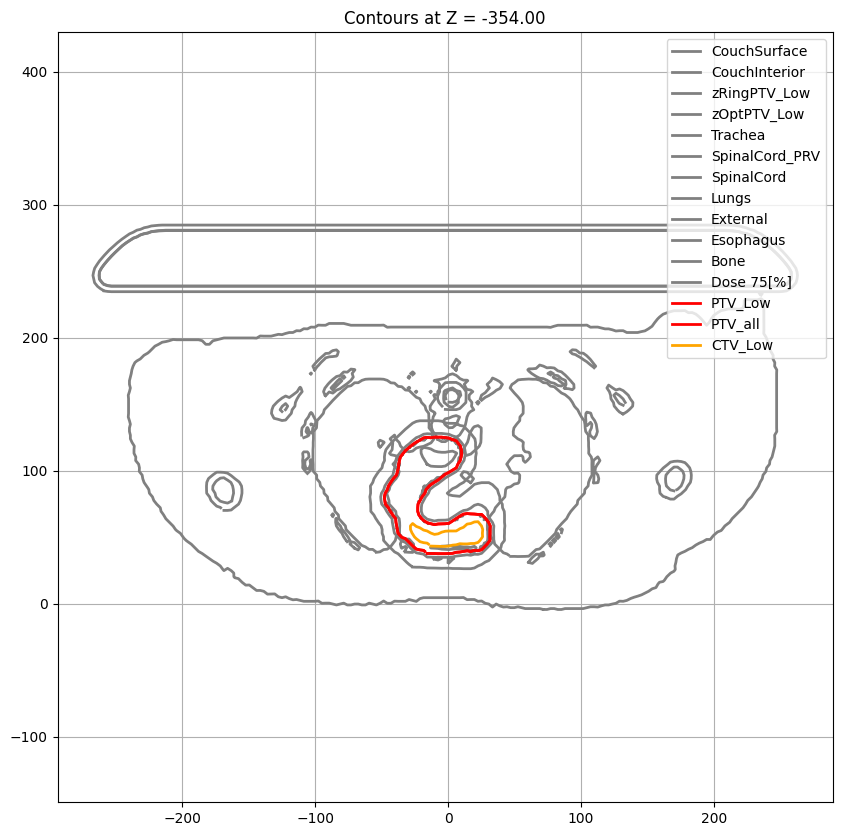

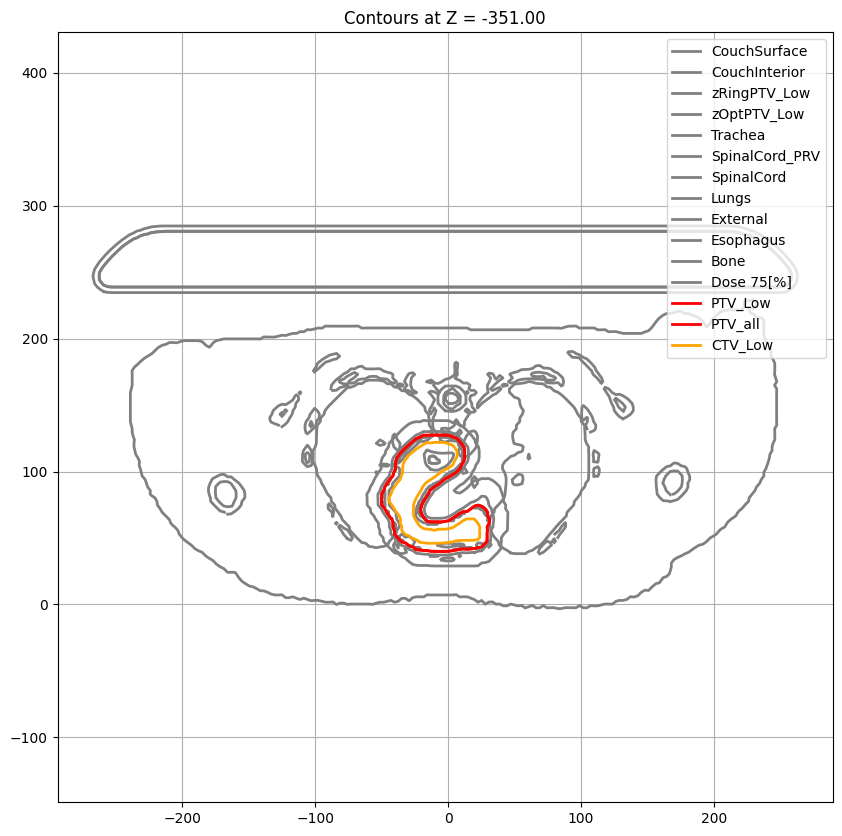

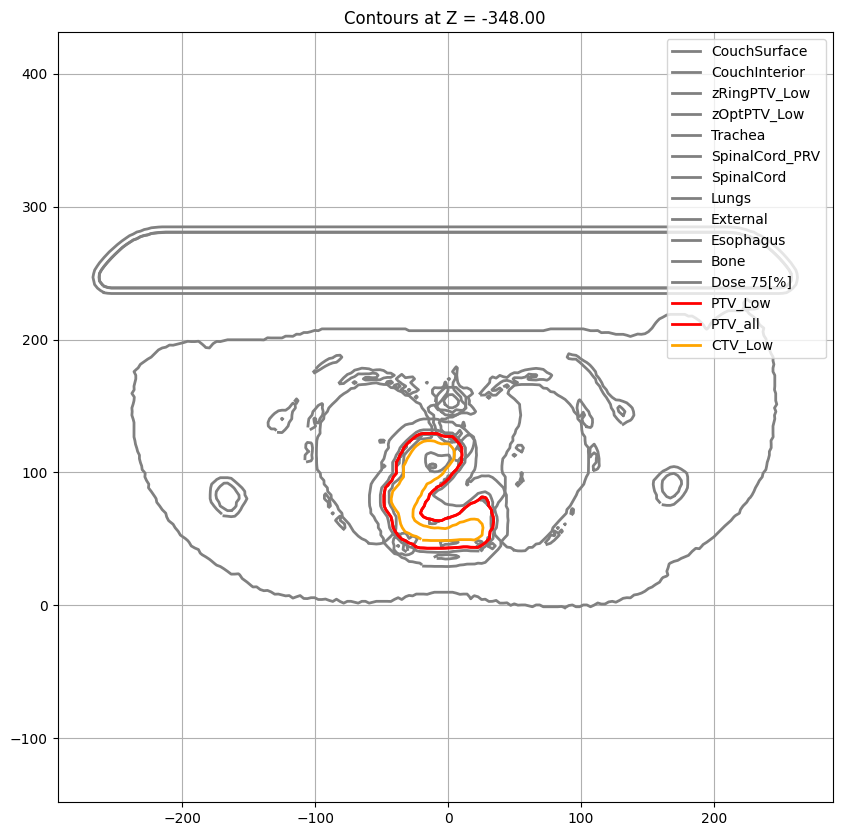

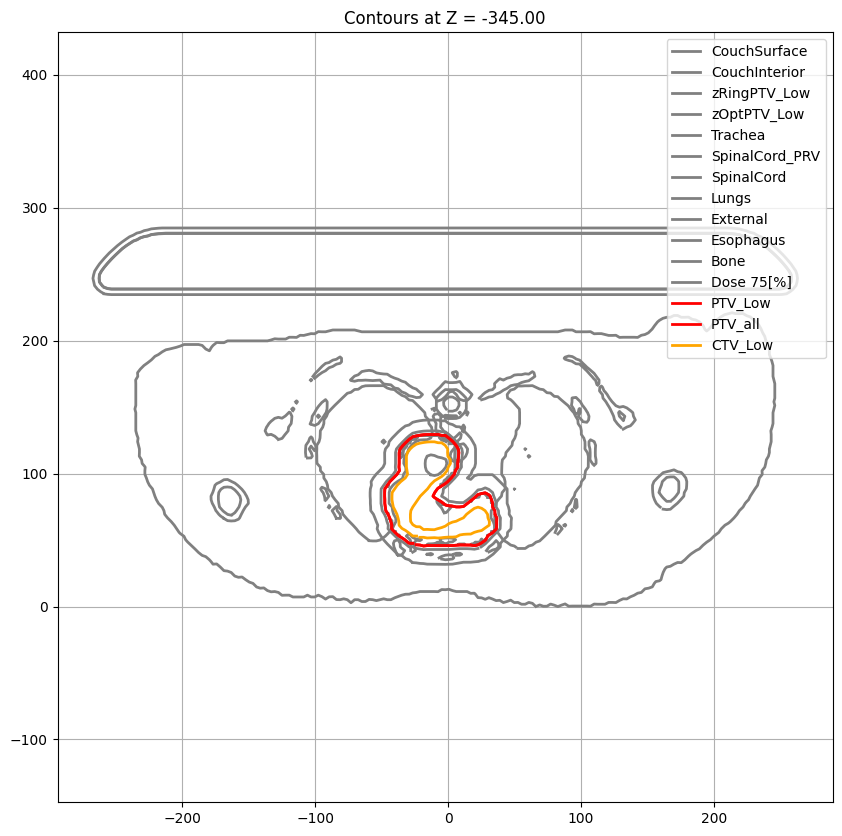

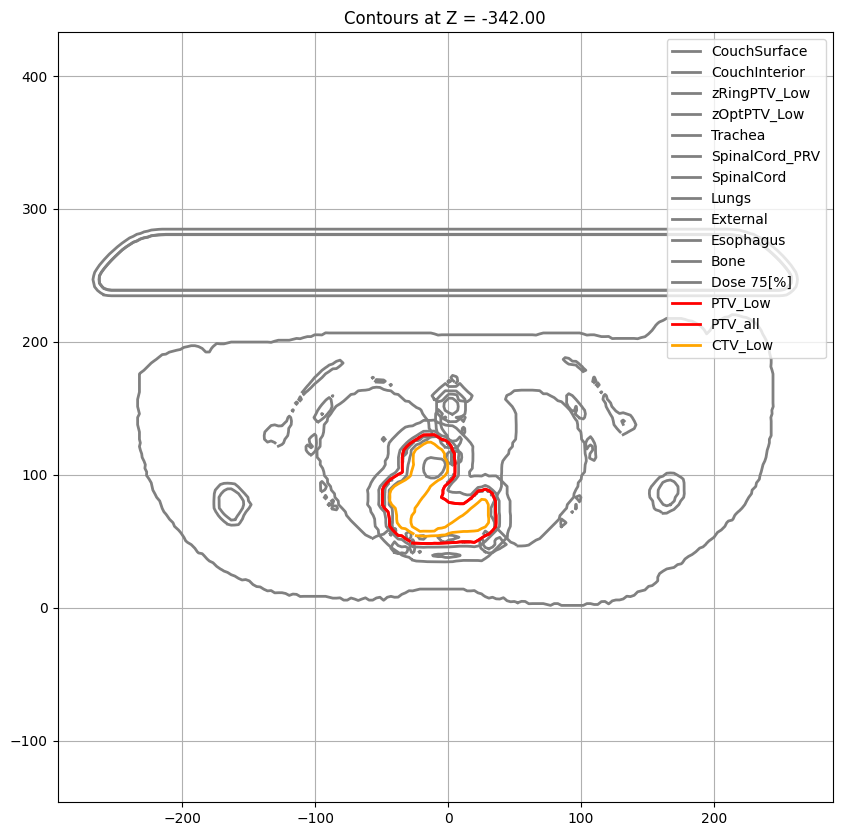

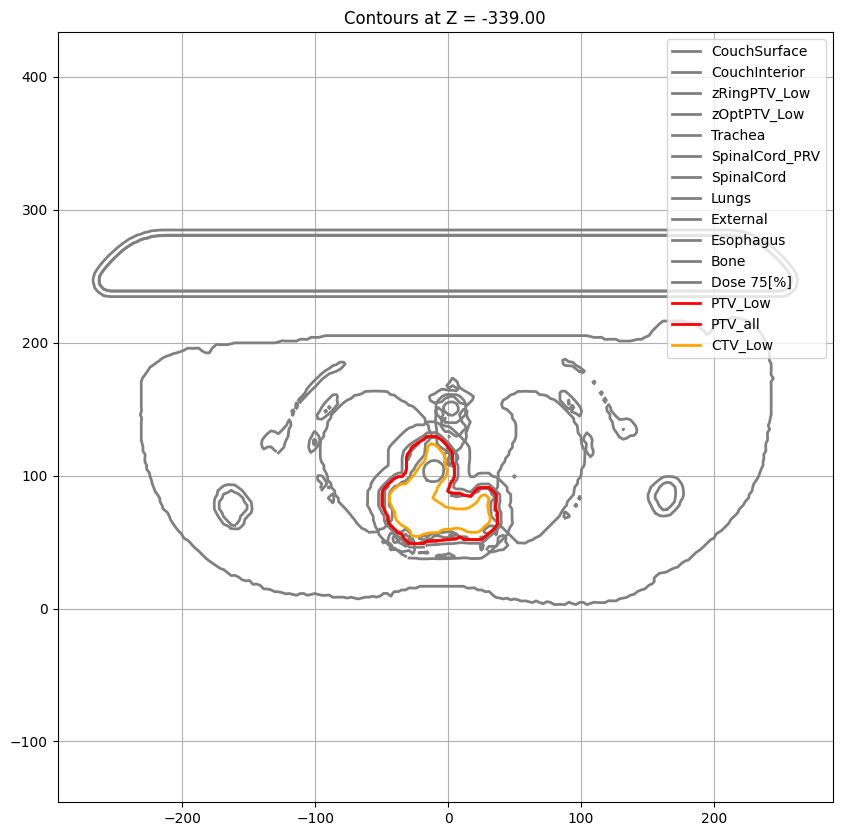

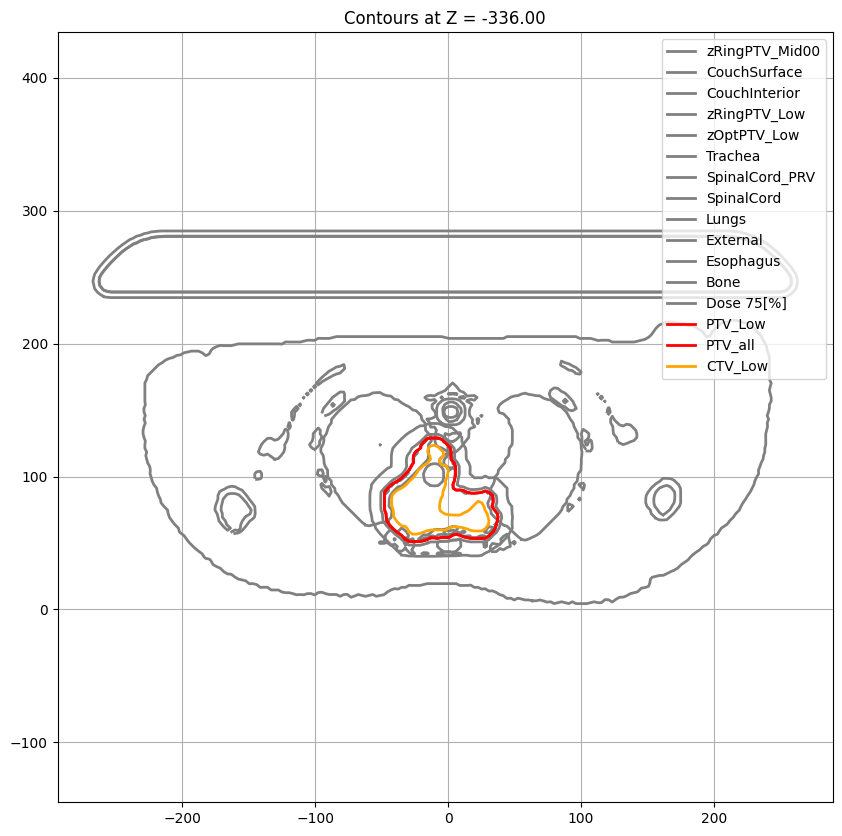

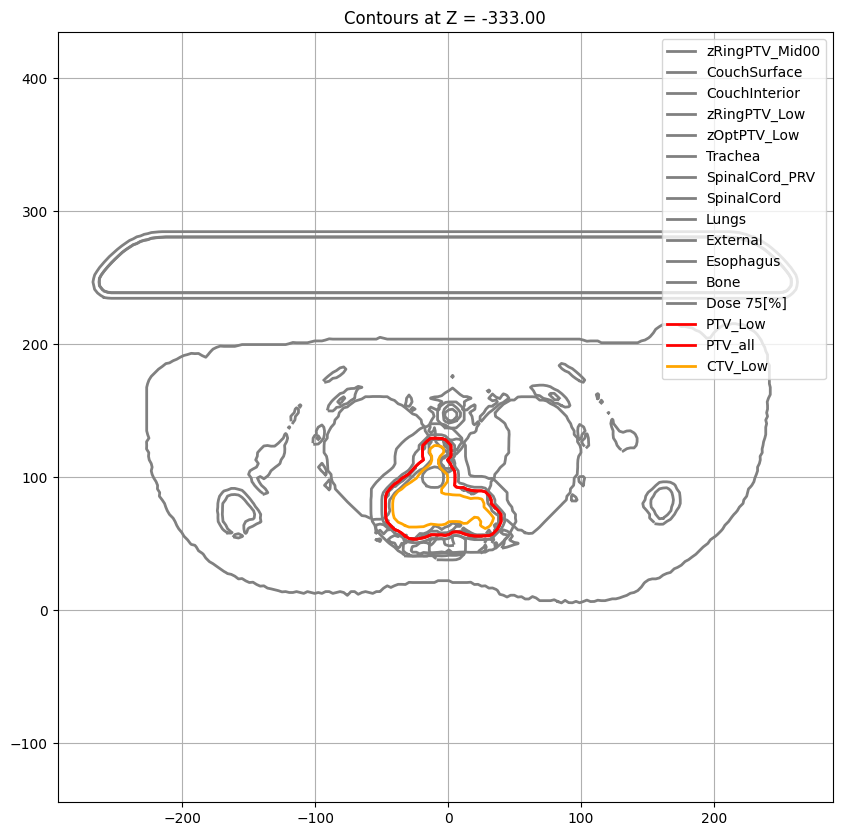

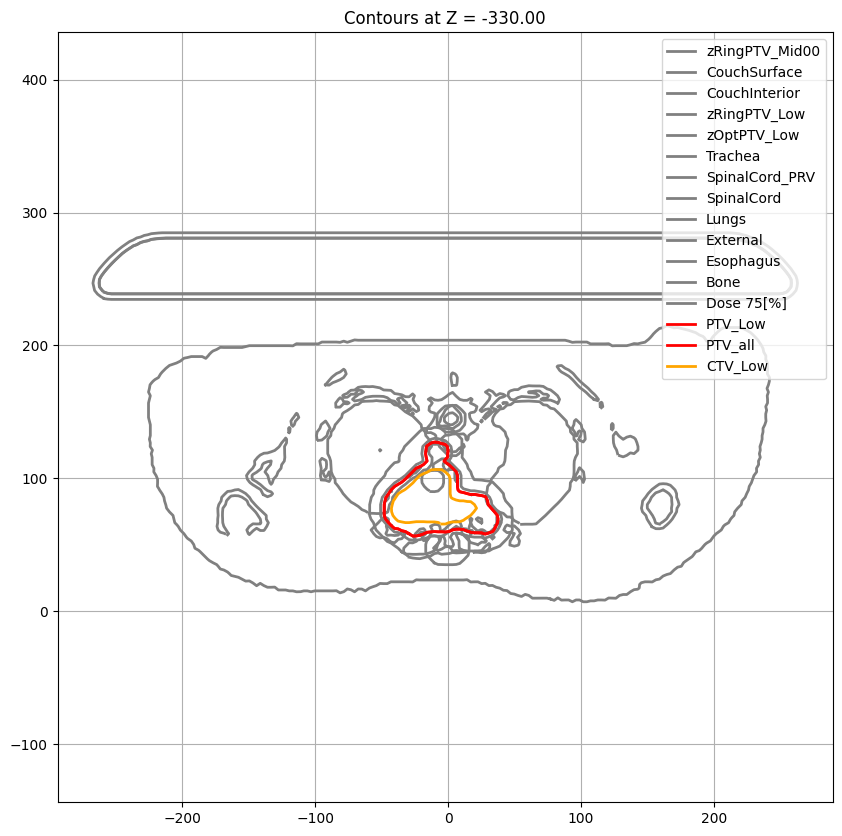

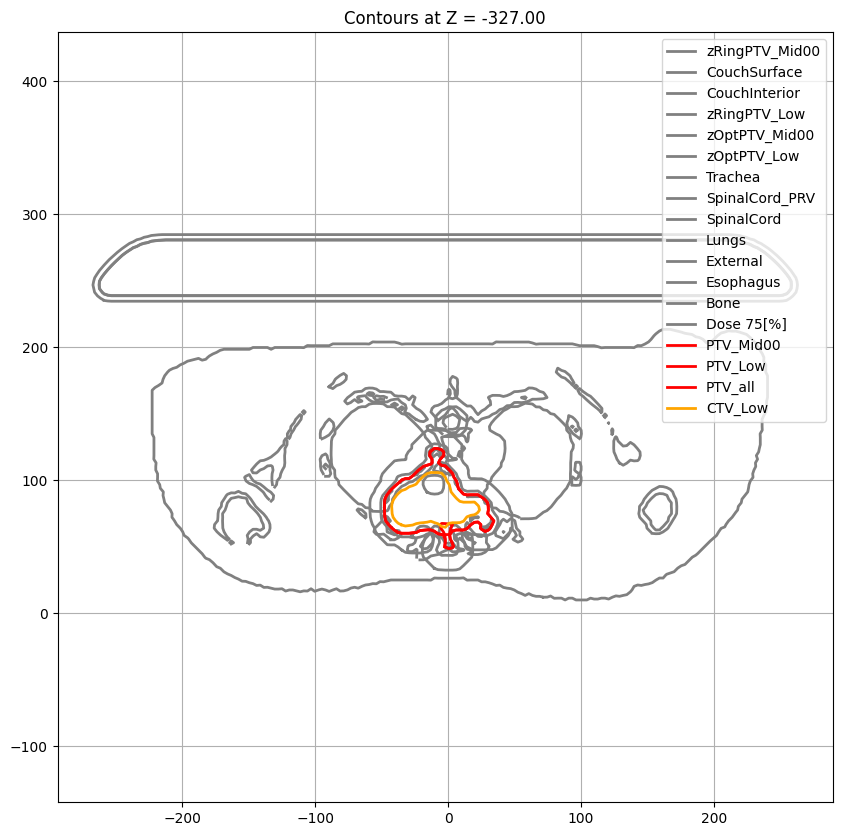

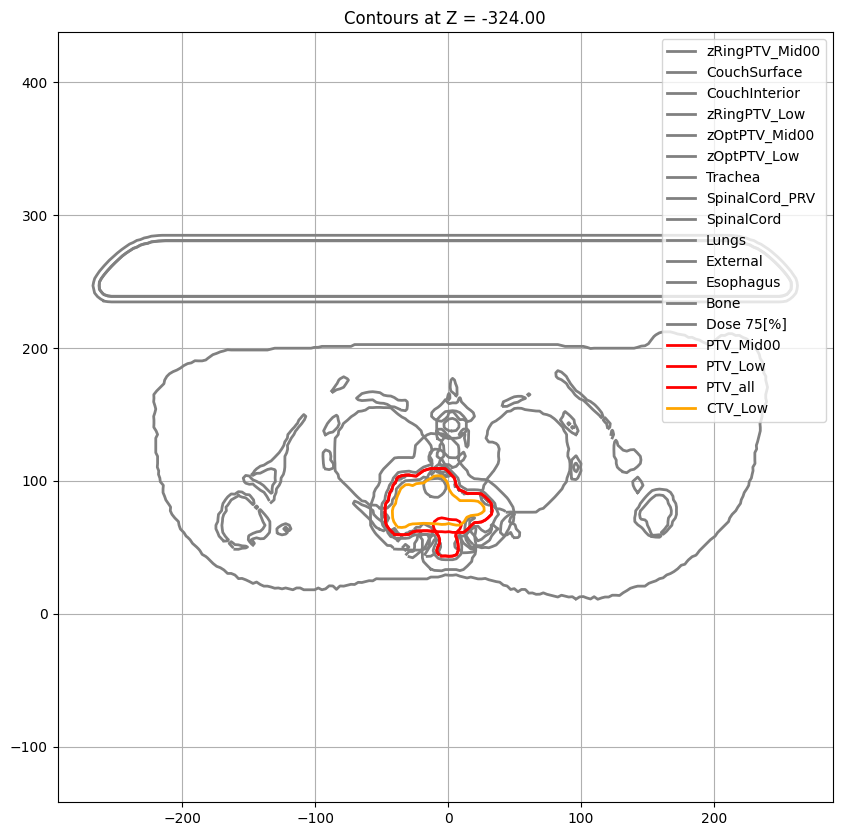

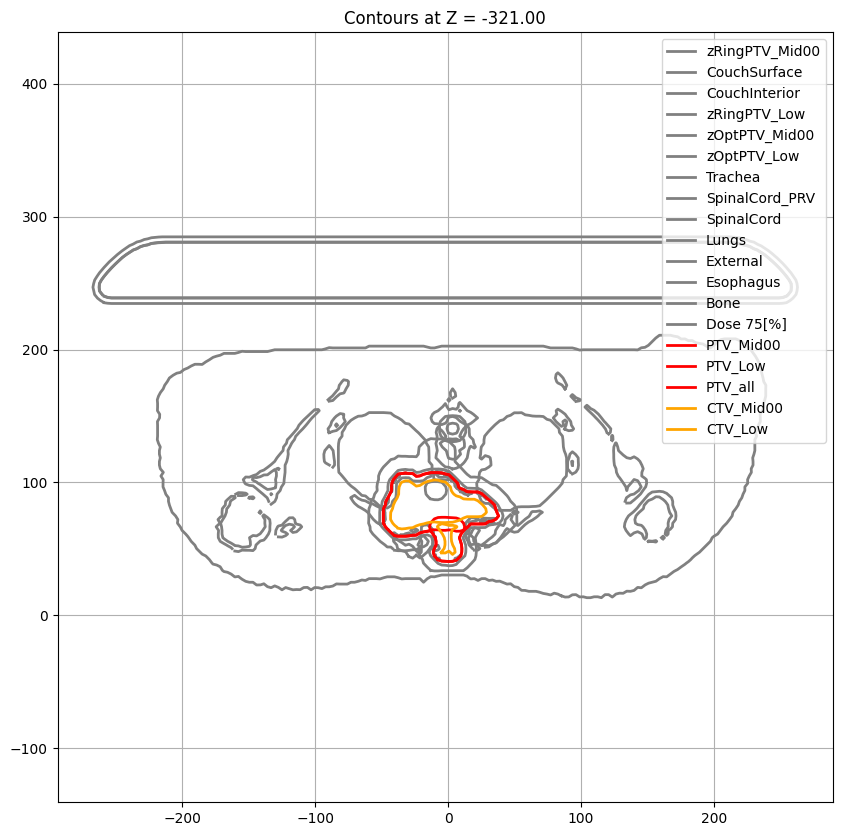

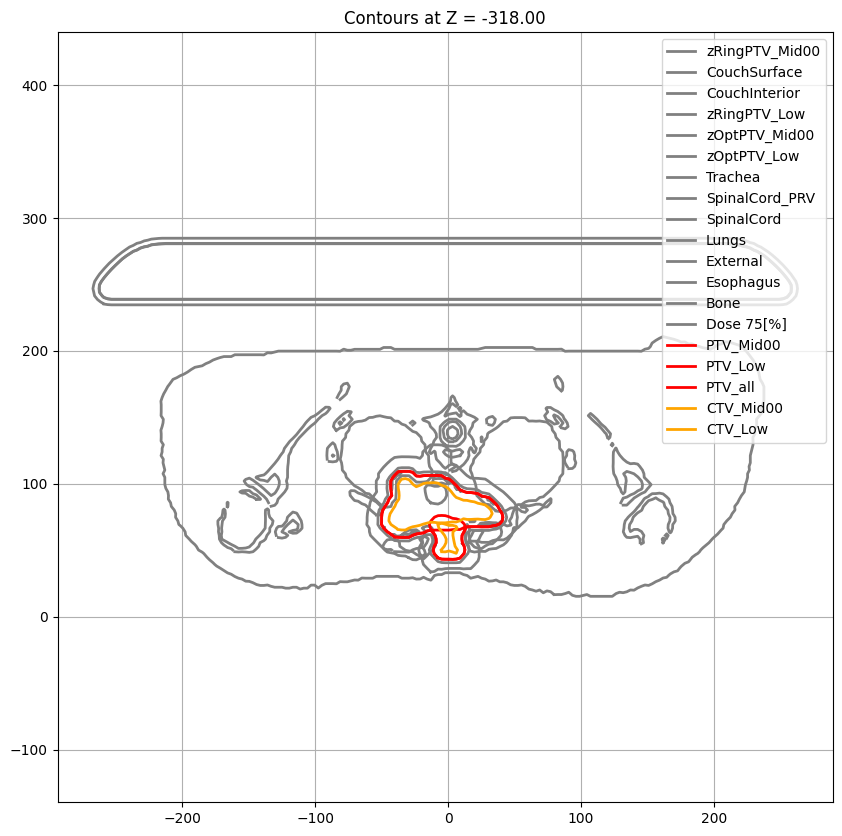

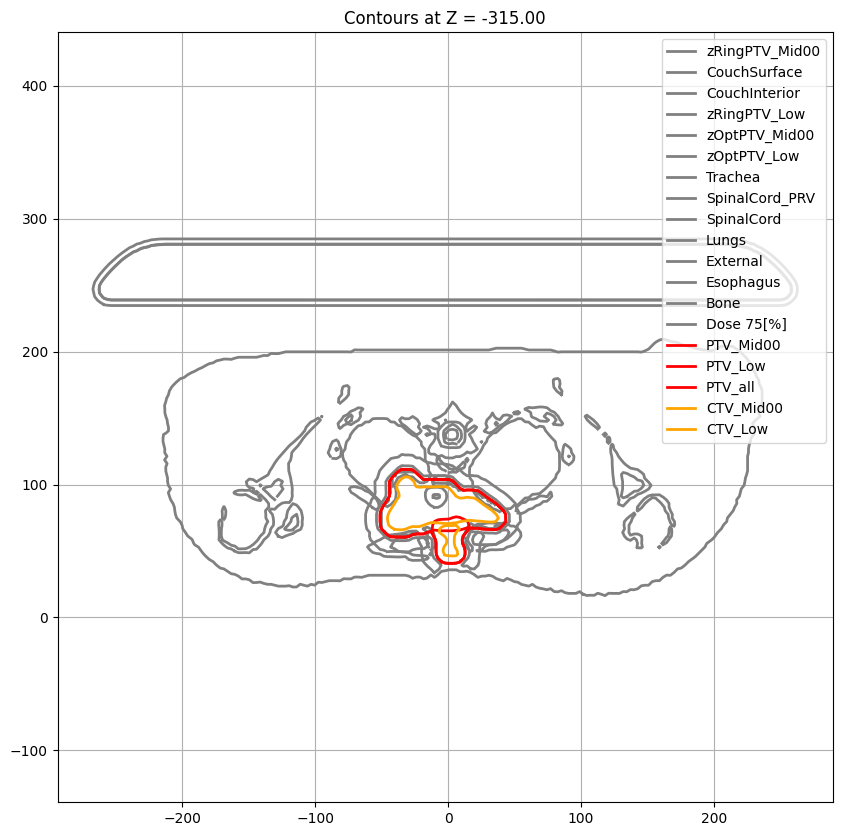

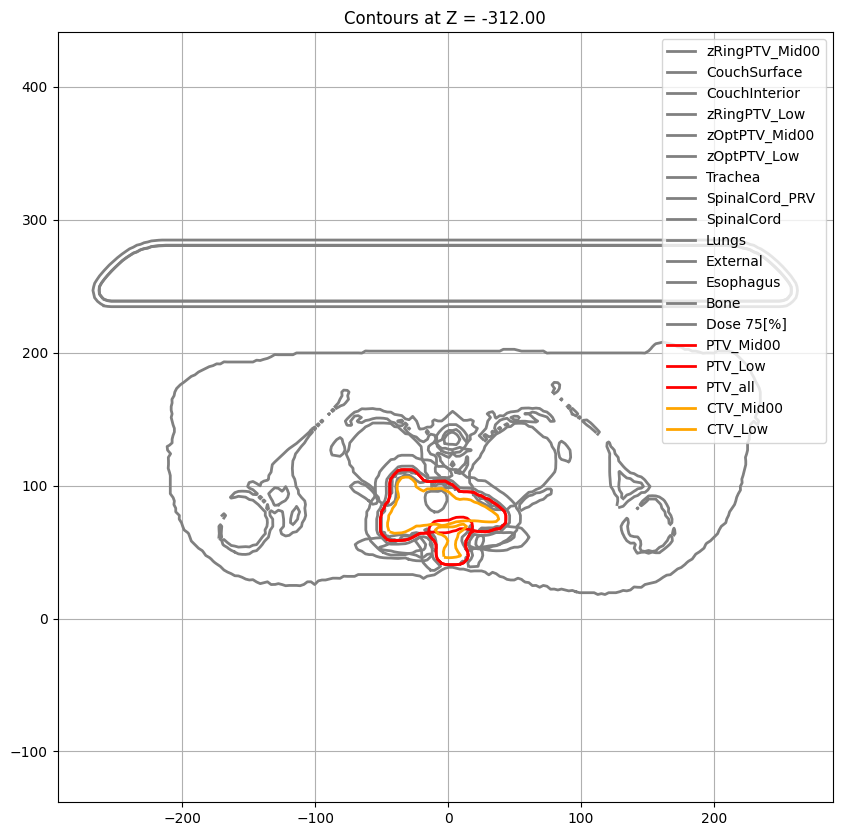

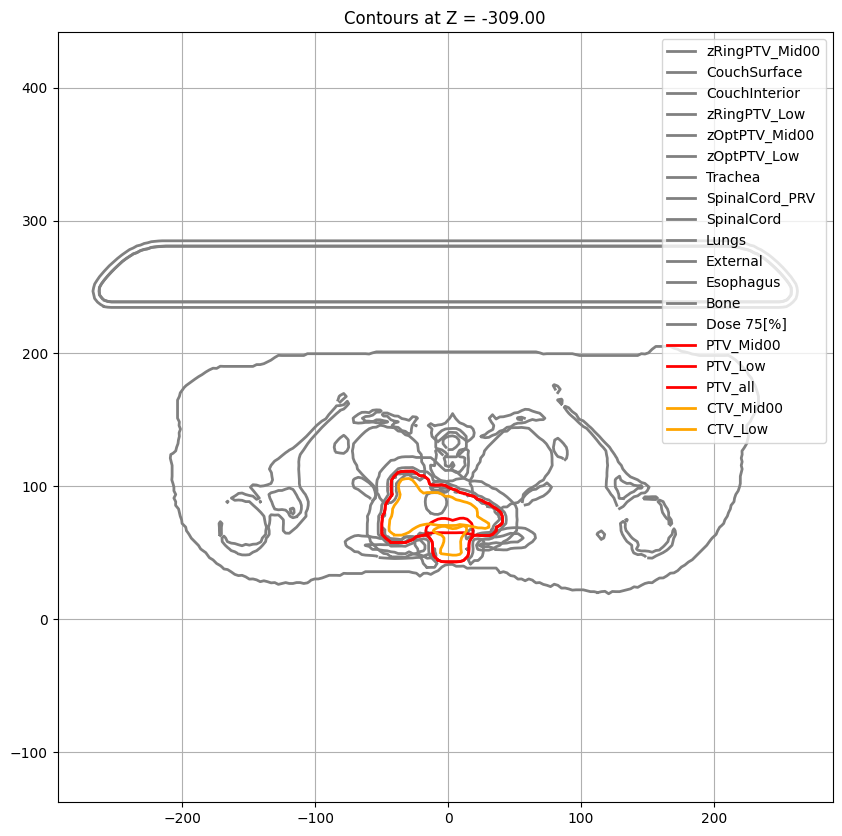

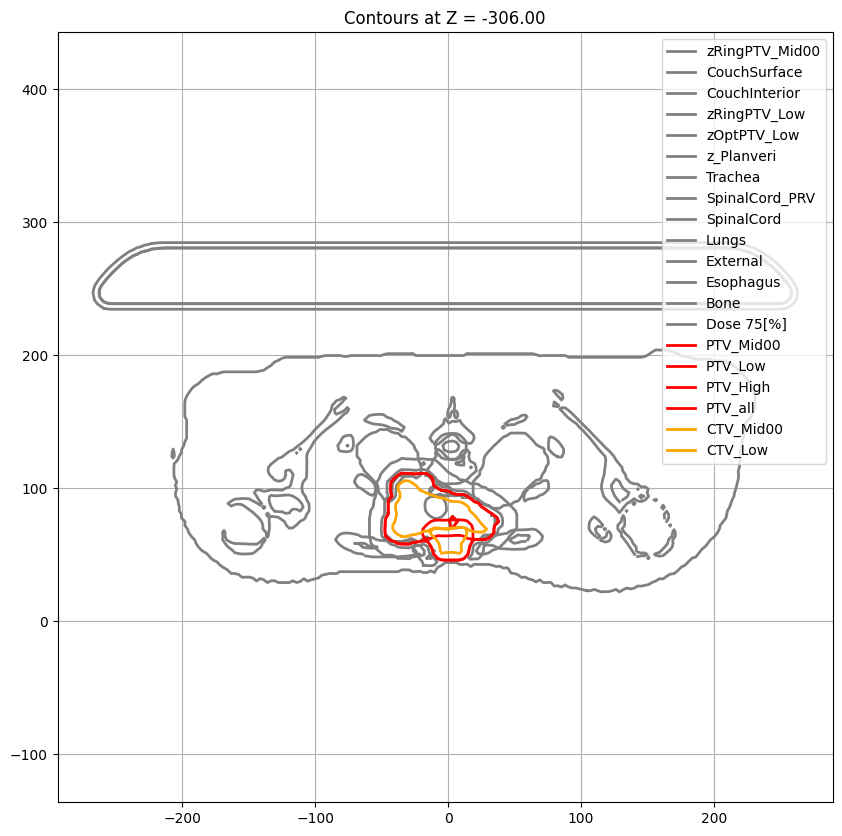

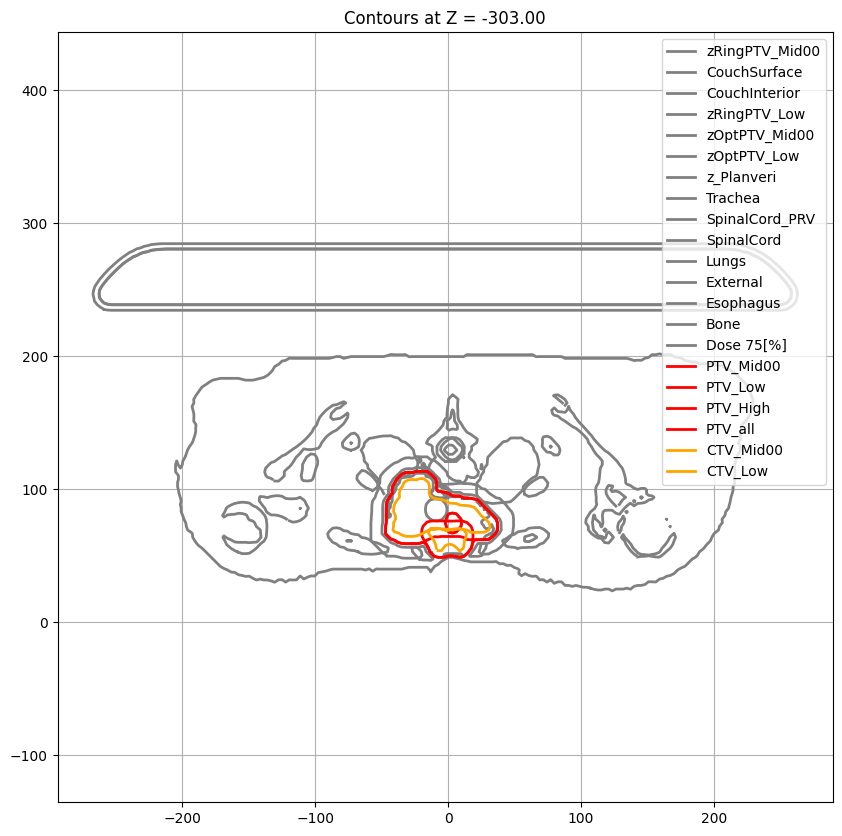

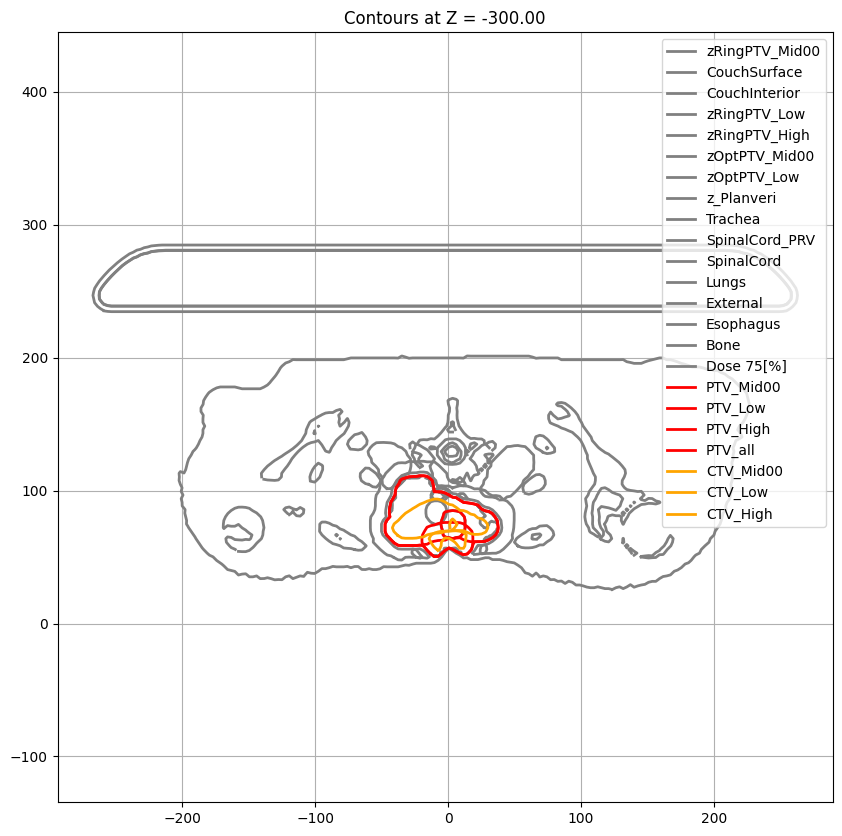

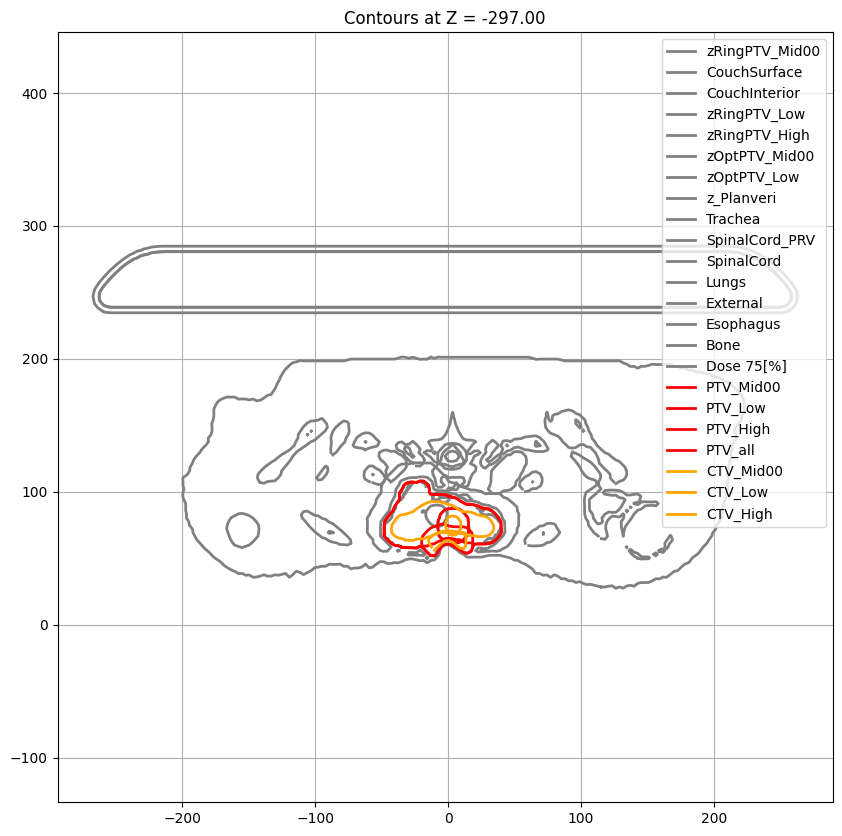

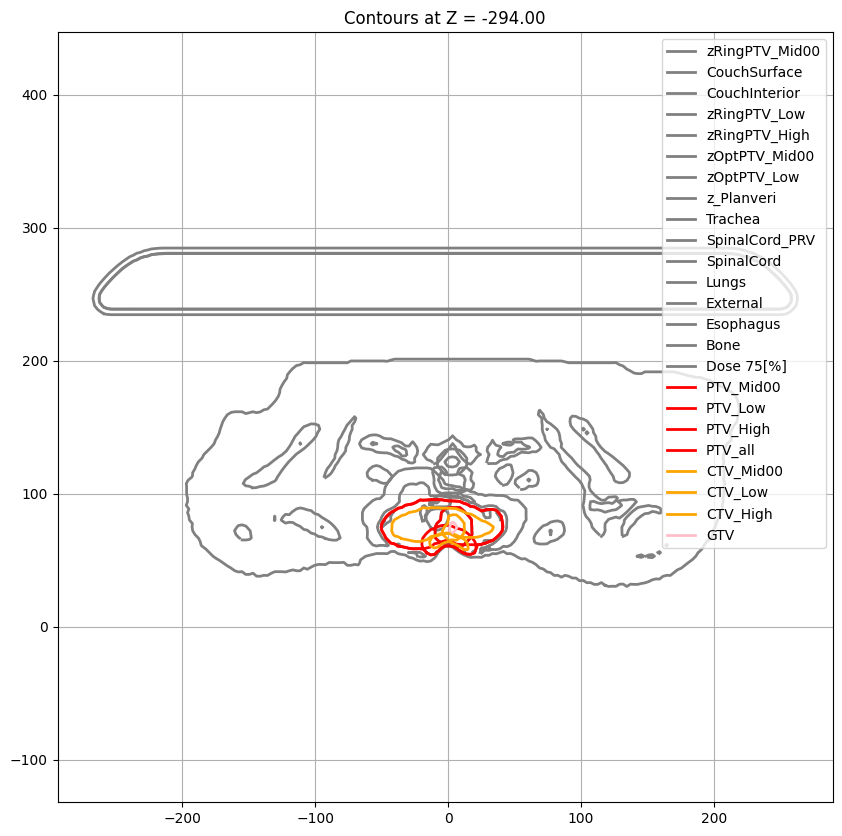

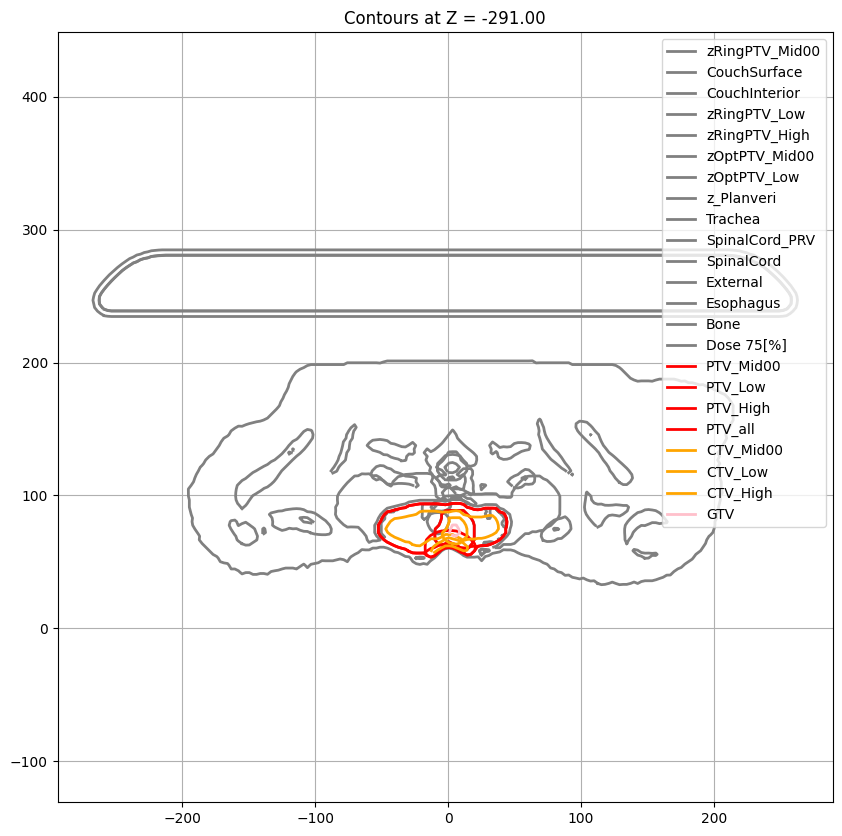

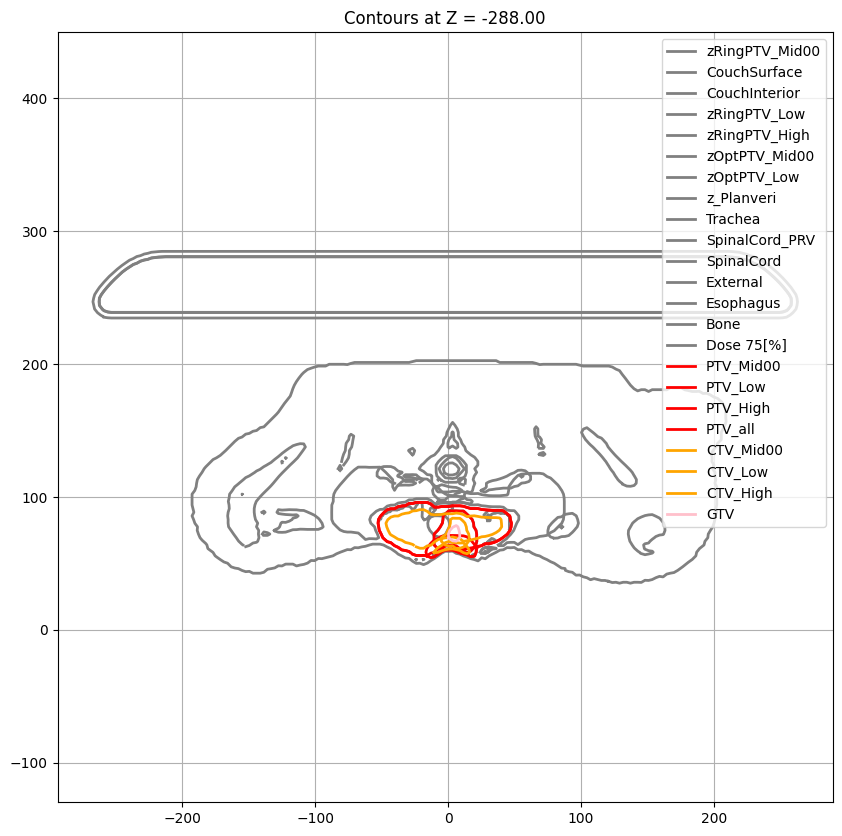

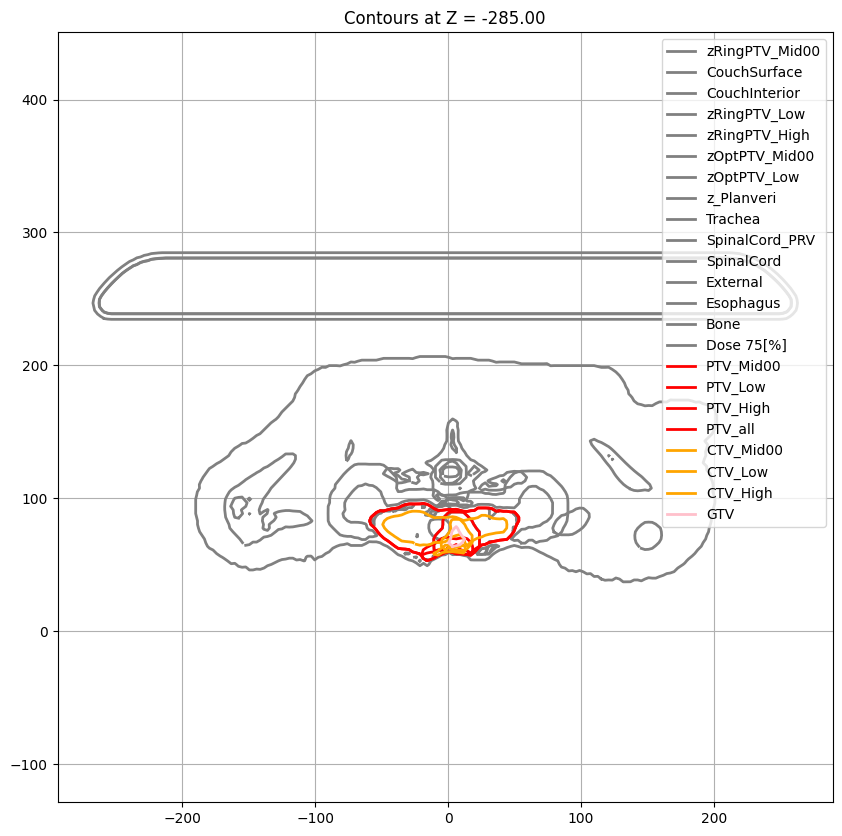

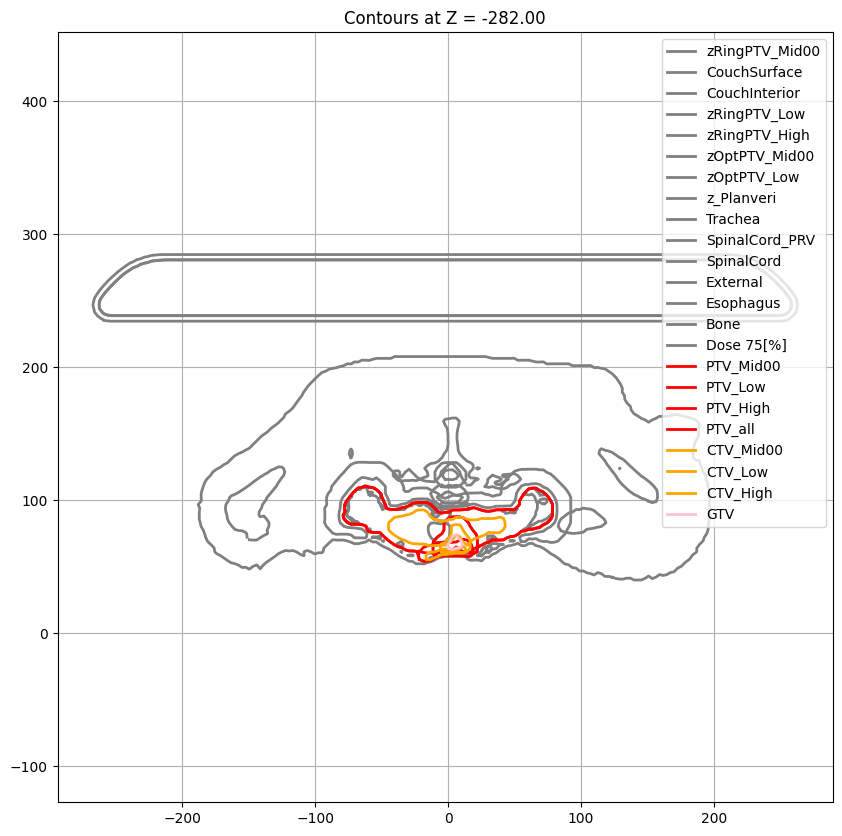

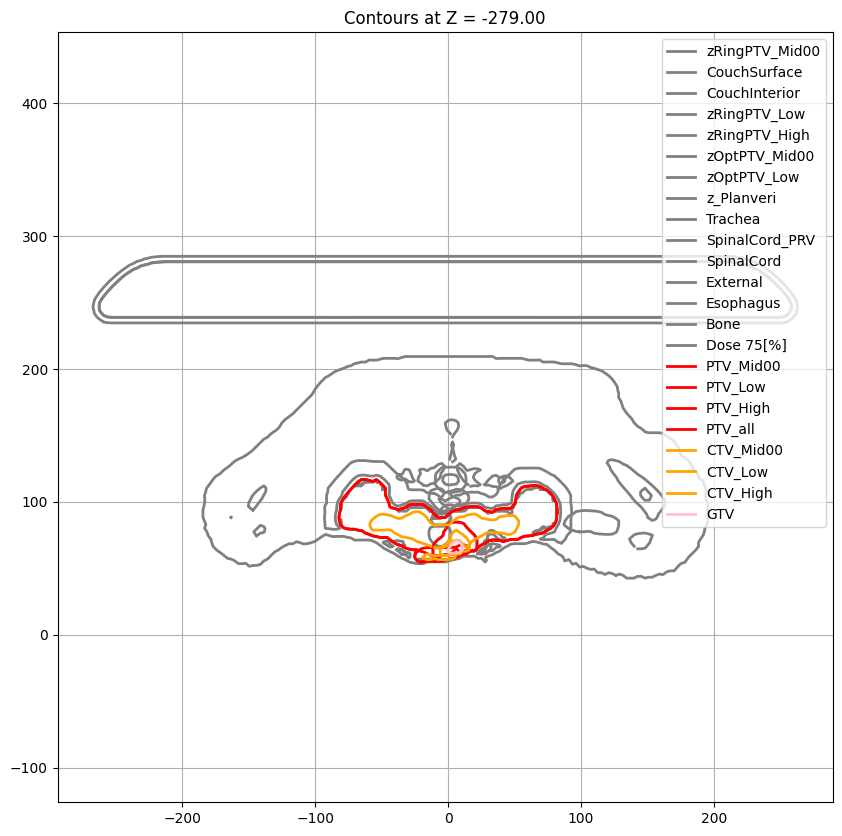

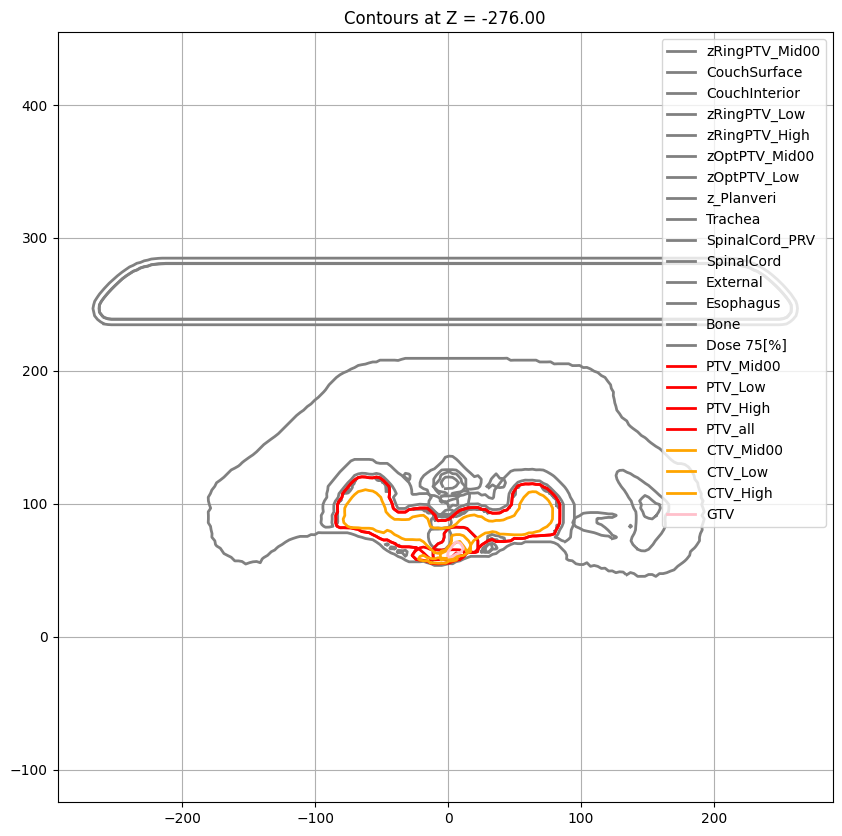

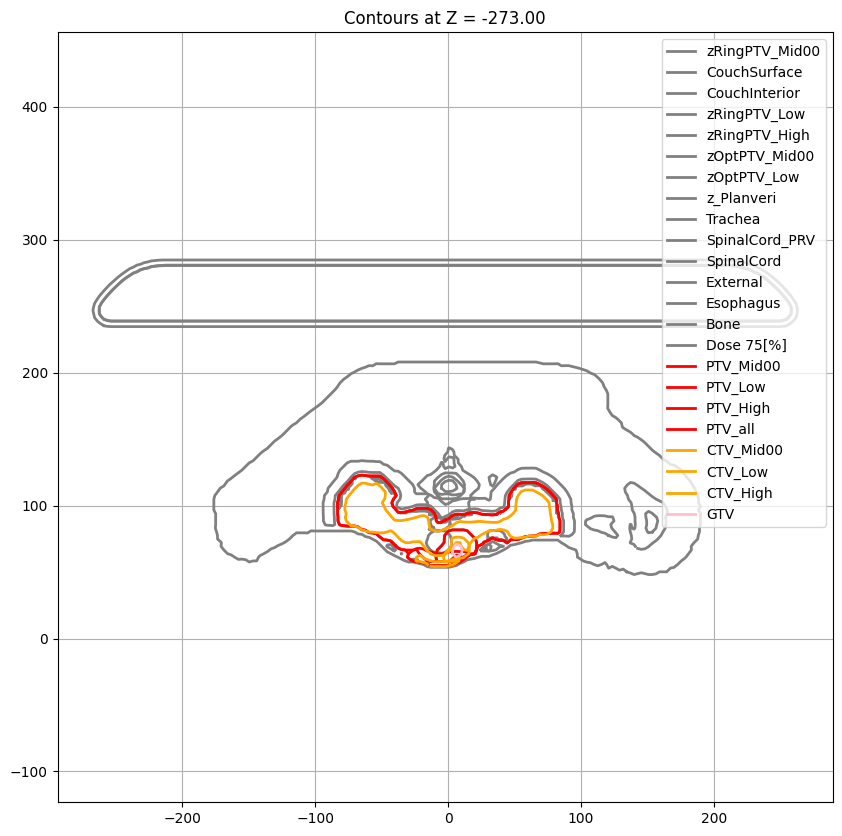

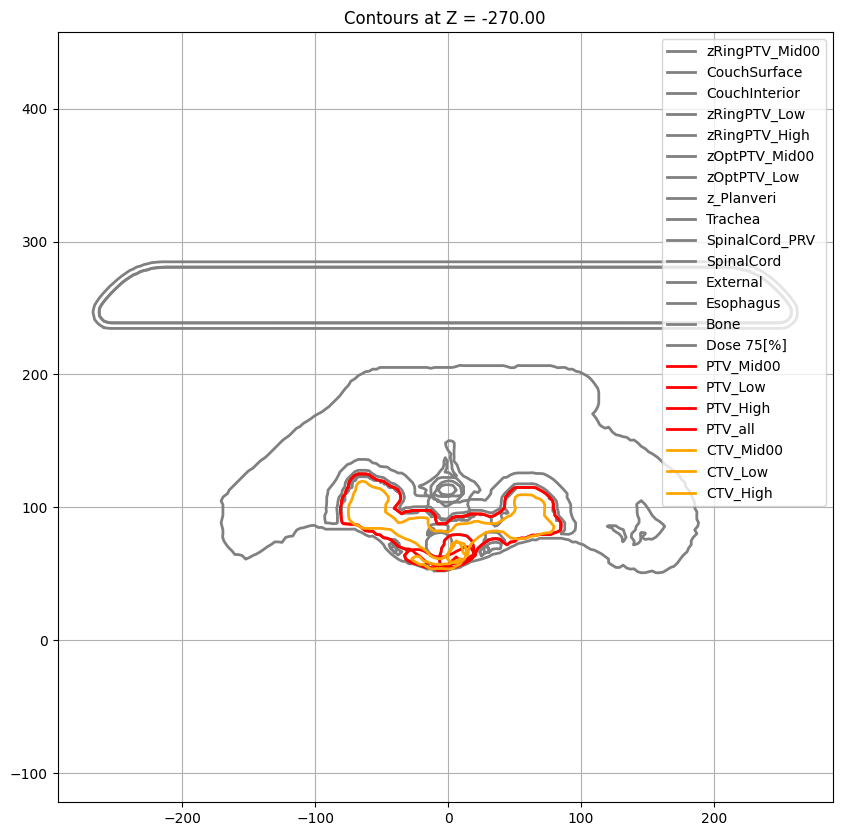

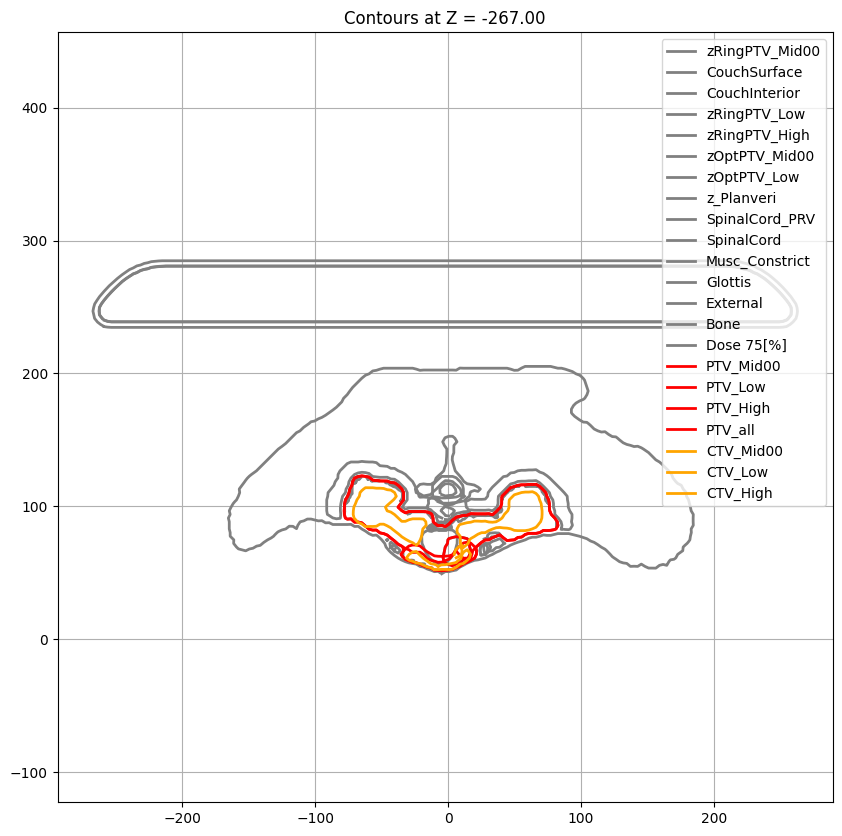

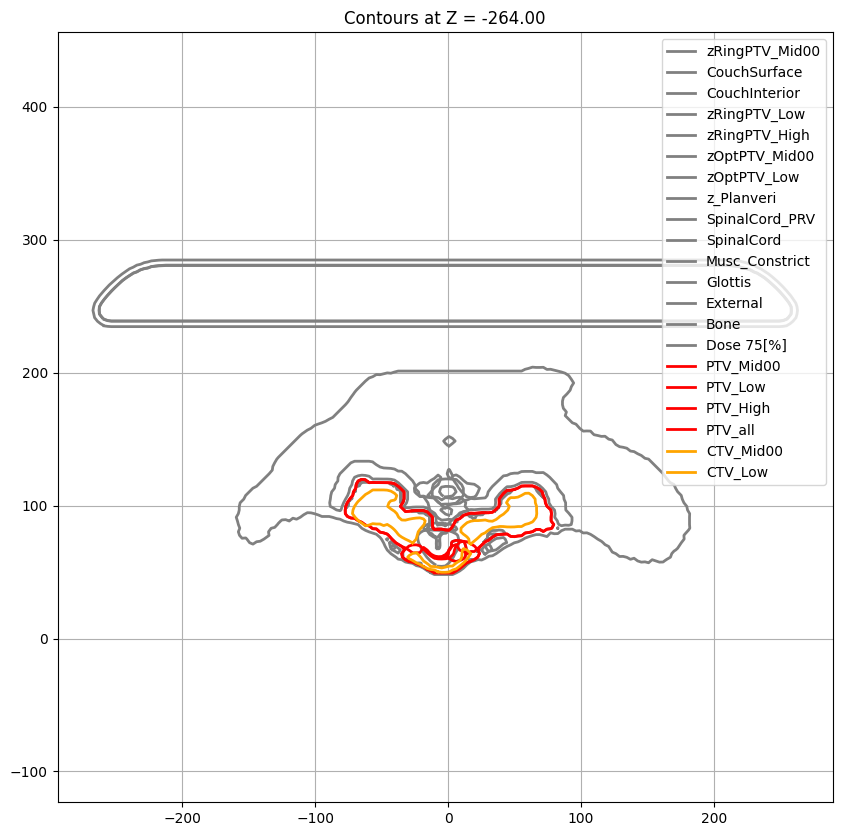

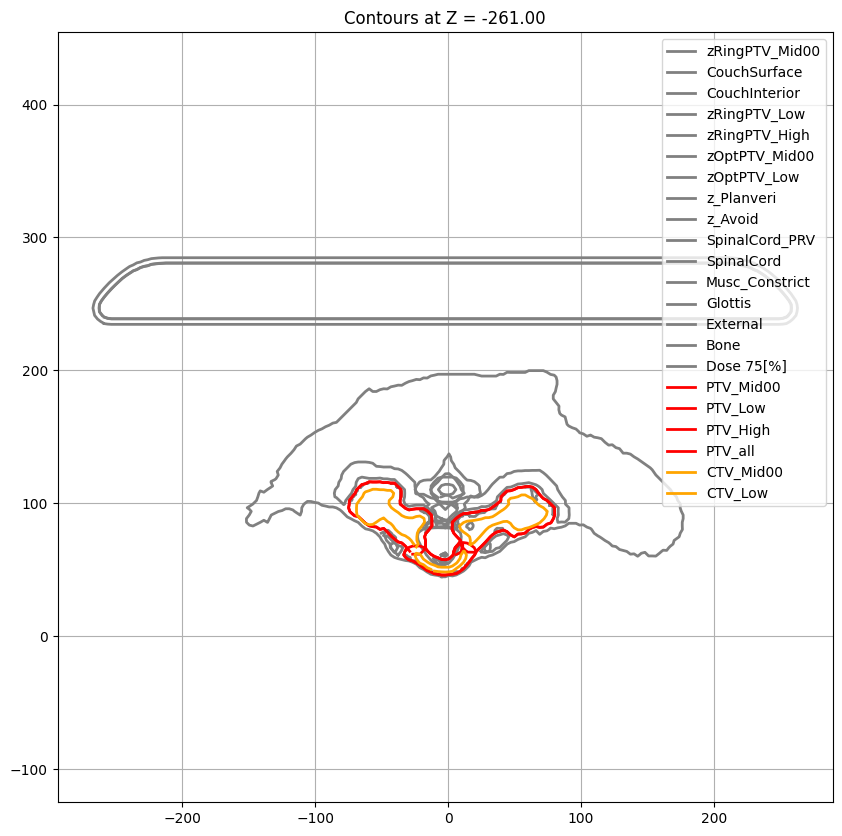

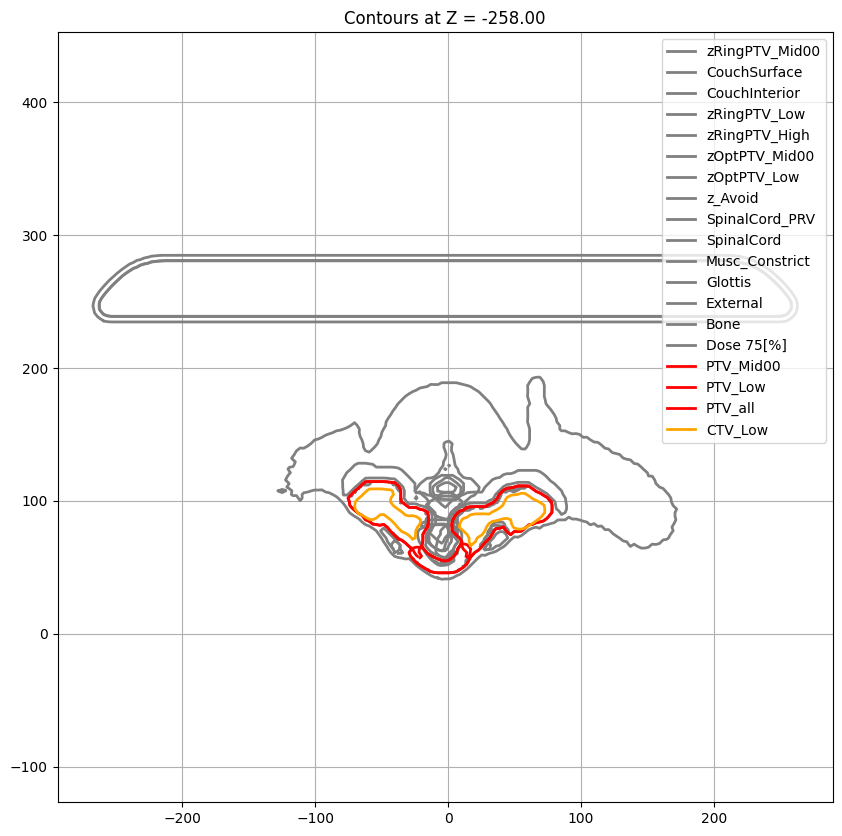

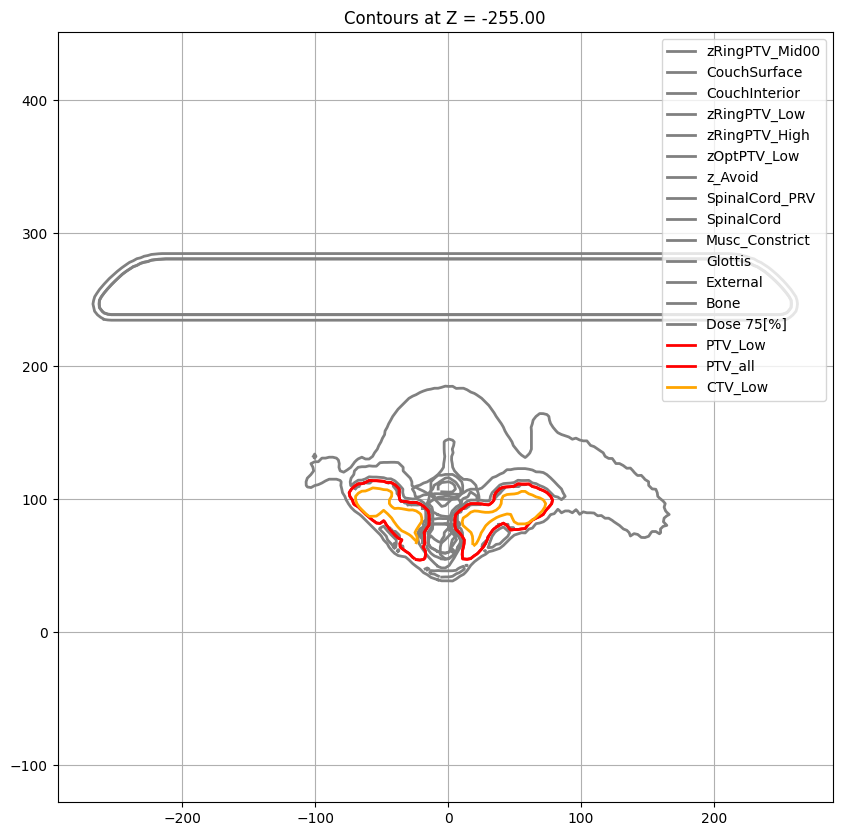

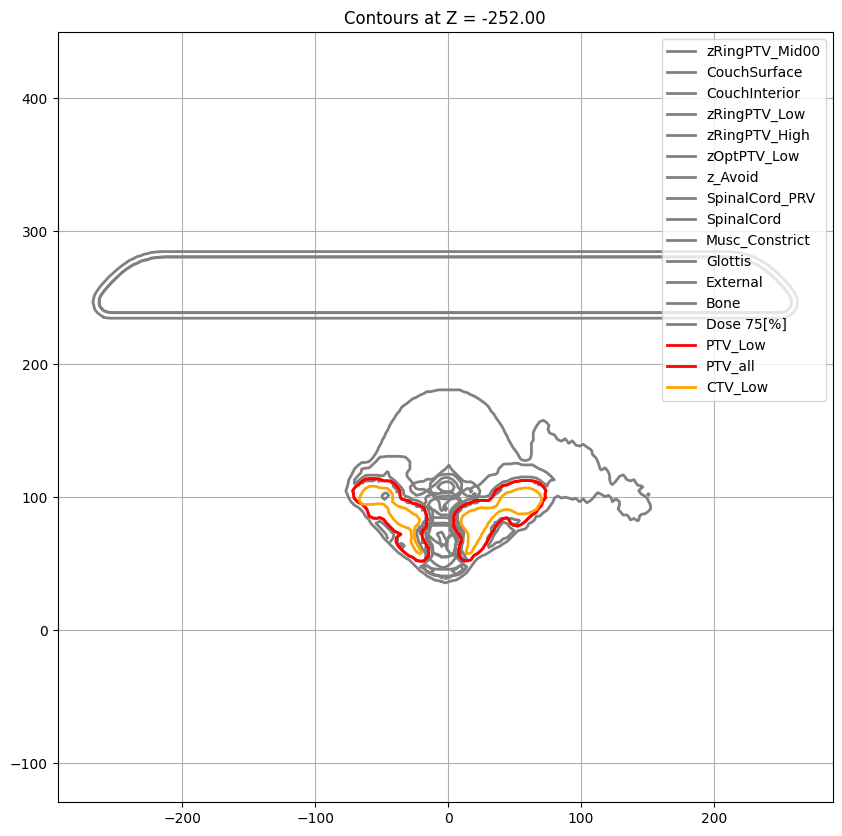

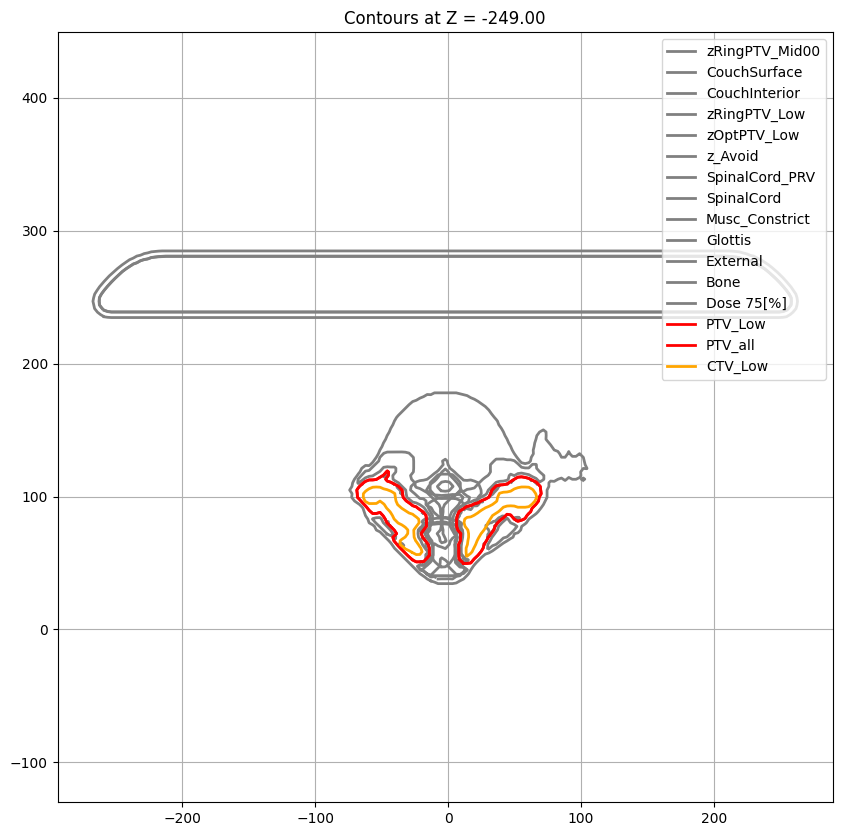

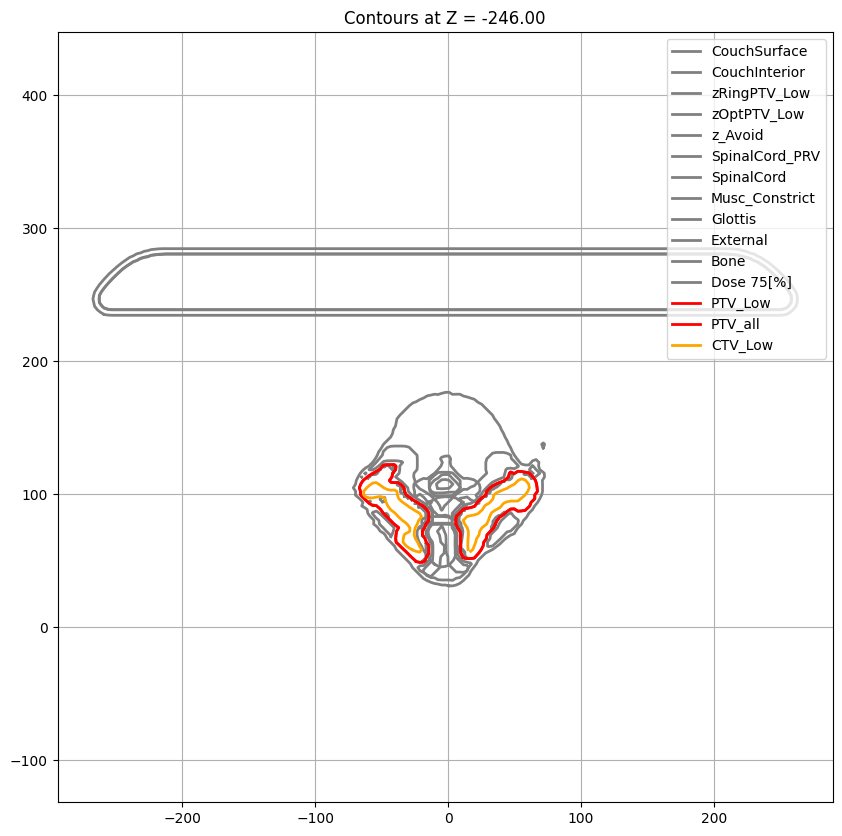

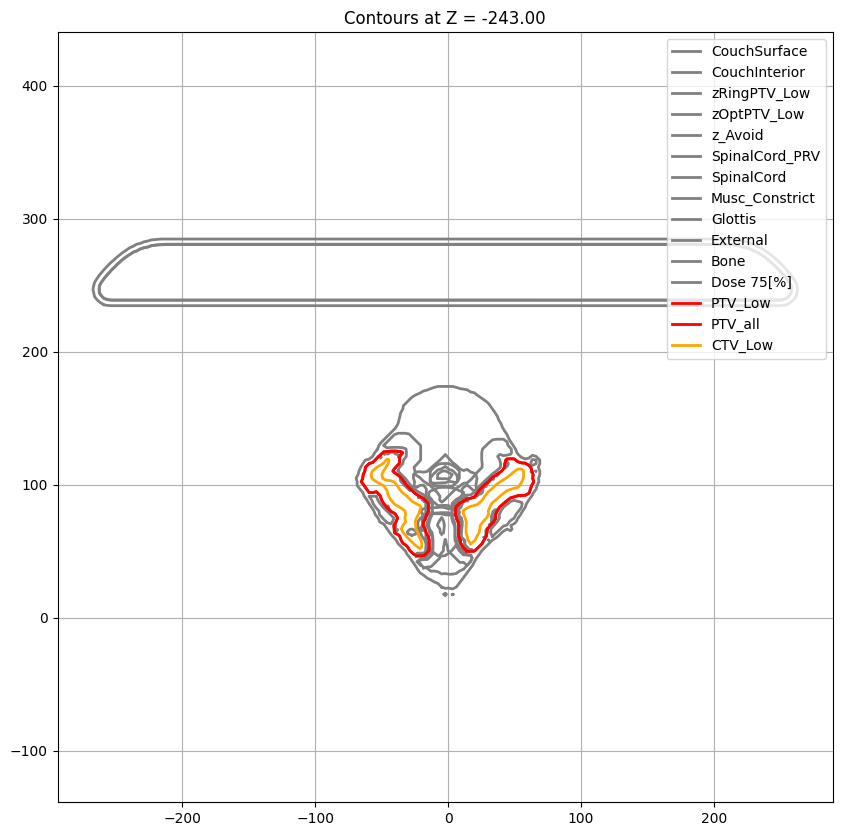

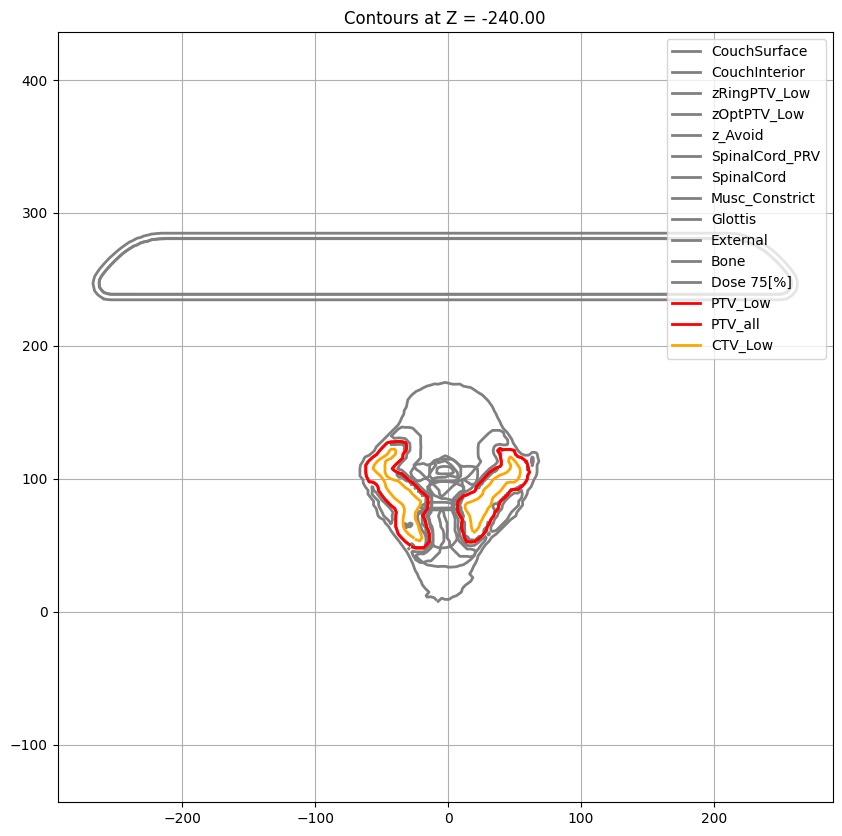

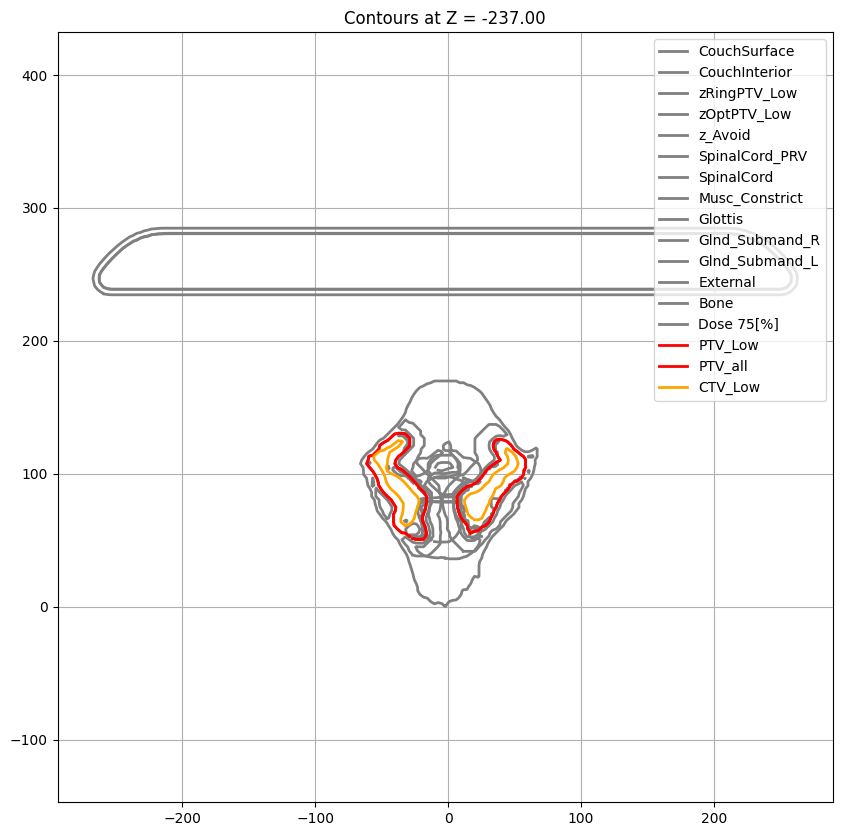

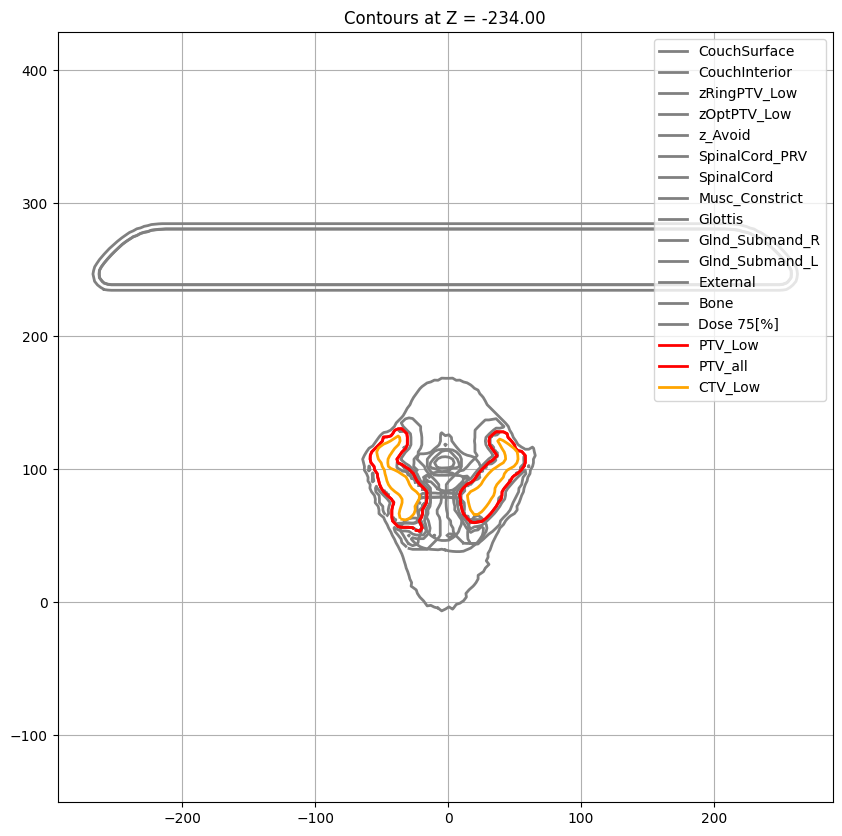

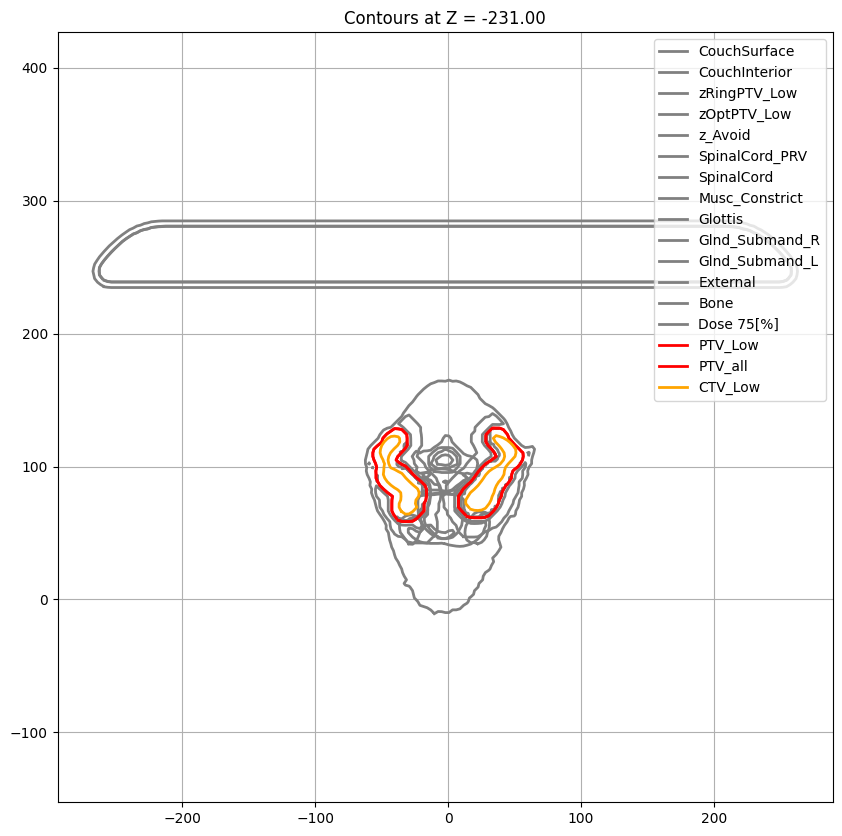

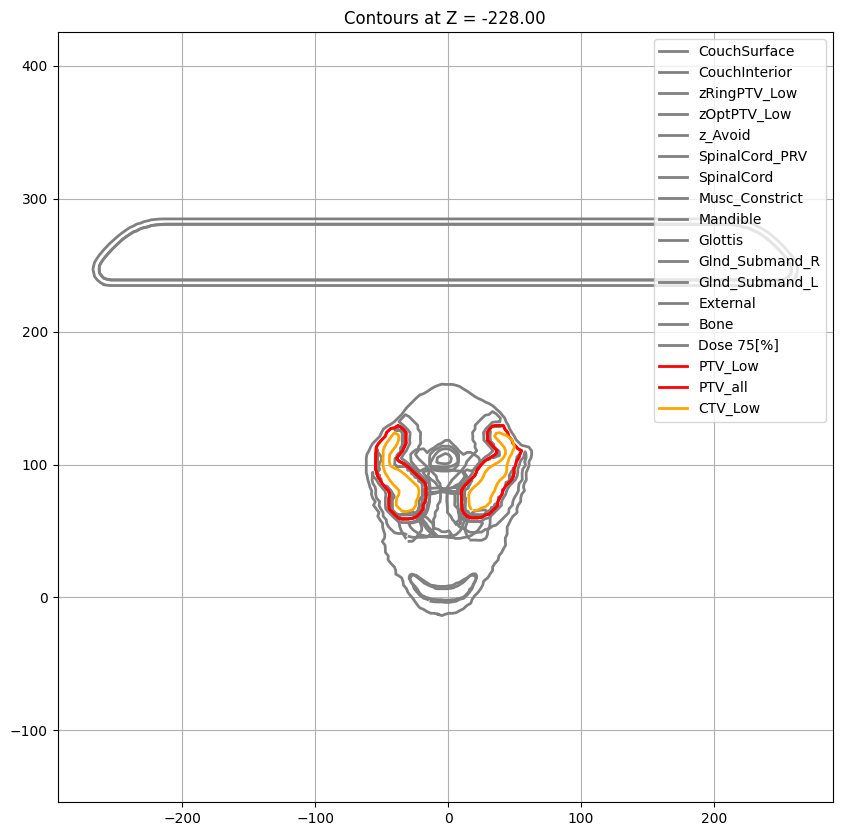

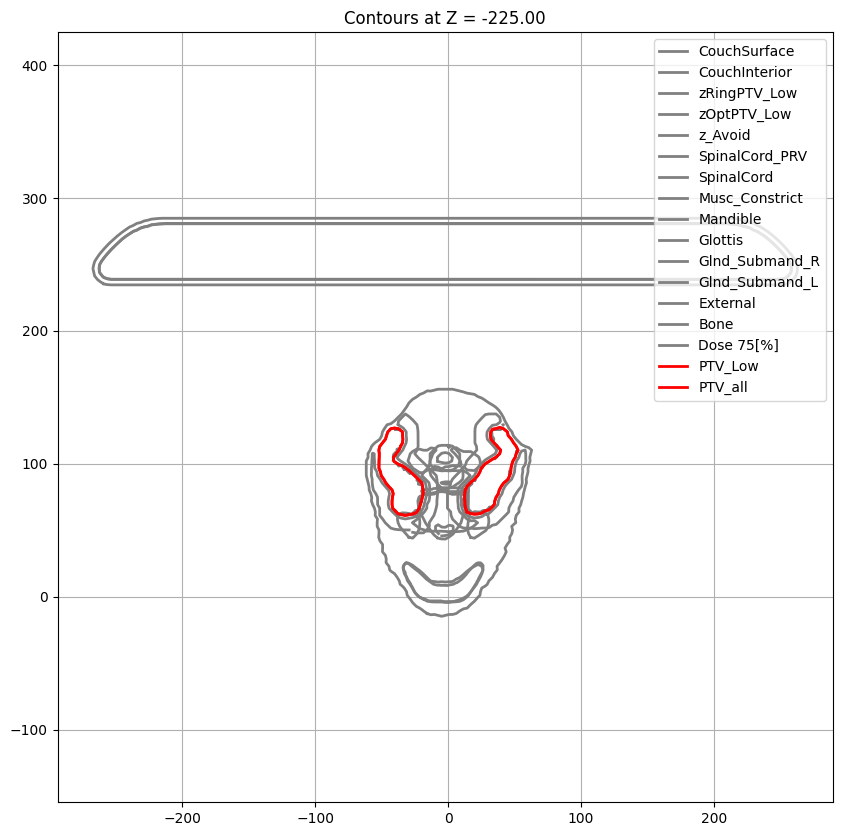

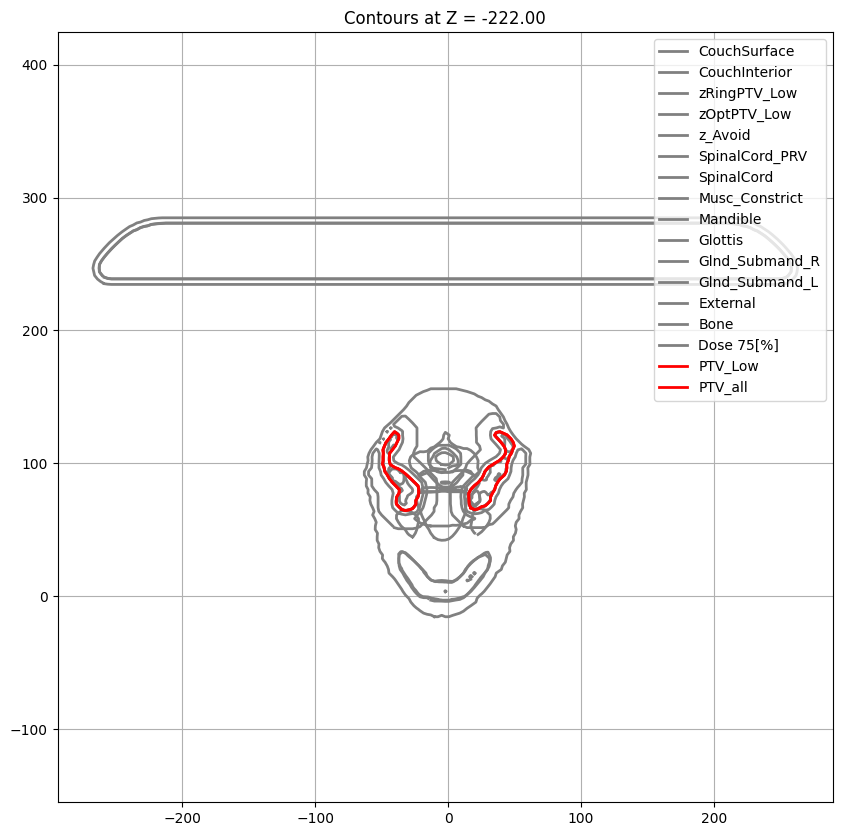

Done


In [19]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt

def get_contours(rtstruct):
    # Function to extract contours from RTSTRUCT
    contours = {}
    
    # Get ROI (Region of Interest) names from the structure set
    roi_names = {roi.ROINumber: roi.ROIName for roi in rtstruct.StructureSetROISequence}
    
    # Extract contour data
    for roi in rtstruct.ROIContourSequence:
        roi_number = roi.ReferencedROINumber
        roi_name = roi_names[roi_number]
        contours[roi_name] = []
        
        # Check if this ROI has contours
        if hasattr(roi, 'ContourSequence'):
            for contour in roi.ContourSequence:
                # Extract contour points
                contour_data = contour.ContourData
                # Convert flat array to points (x,y,z)
                points = np.array(contour_data).reshape(-1, 3)
                contours[roi_name].append(points)
    
    return contours


def visualize_contours_2d(contours_dict):
    # Function to visualize contours in 2D (for each axial slice)
    # Define colors for each ROI
    colors = {
        "PTV": "red",
        "CTV": "orange",
        "GTV": "pink"
    }
    
    # Find all unique Z positions across all contours
    all_z_positions = []
    for roi_name, roi_contours in contours_dict.items():
        for contour in roi_contours:
            z_positions = np.unique(contour[:, 2])
            all_z_positions.extend(z_positions)
    
    unique_z_positions = np.unique(all_z_positions)
    print(f"Found {len(unique_z_positions)} unique Z positions")
    
    # Create a plot for each unique Z position (slice)
    for z_pos in unique_z_positions:
        plt.figure(figsize=(10, 10))
        plt.title(f"Contours at Z = {z_pos:.2f}")
        
        # Add each ROI's contours that match this Z position
        for roi_name, roi_contours in contours_dict.items():
            if roi_name.startswith("GTV") or \
                roi_name.startswith("CTV") or \
                roi_name.startswith("PTV"):
                continue
            color = colors.get(roi_name, 'gray')
            
            for contour in roi_contours:
                # Get points that match this Z position (with small tolerance)
                mask = np.abs(contour[:, 2] - z_pos) < 0.1
                if np.any(mask):
                    points = contour[mask]
                    x, y = points[:, 0], points[:, 1]
                    plt.plot(x, y, '-', color=color, linewidth=2, label=roi_name)
                    
                    # If it's an isocenter marker, it might be just a point
                    if len(x) <= 1:
                        plt.scatter(x, y, color=color, s=100, marker='o')

        # Draw tumors over background
        tumor = False
        ptv_contours_items = []
        ctv_contours_items = []
        gtv_contours_items = []
        for roi_name, roi_contours in contours_dict.items():
            if roi_name.startswith("GTV"):
                gtv_contours_items.append((roi_name, roi_contours))
            elif roi_name.startswith("CTV"):
                ctv_contours_items.append((roi_name, roi_contours))
            elif roi_name.startswith("PTV"):
                ptv_contours_items.append((roi_name, roi_contours))
            else:
                continue
        for reduced_contours_items in [ptv_contours_items, ctv_contours_items, gtv_contours_items]:
            # Add each ROI's contours that match this Z position
            for roi_name, roi_contours in reduced_contours_items:
                tumor_in_roi = roi_name.startswith("GTV") or \
                    roi_name.startswith("CTV") or \
                    roi_name.startswith("PTV")
                if tumor_in_roi:
                    # check if mask has any pixels
                    any_pixels = False
                    for contour in roi_contours:
                        # Get points that match this Z position (with small tolerance)
                        mask = np.abs(contour[:, 2] - z_pos) < 0.1
                        if np.any(mask):
                            any_pixels = True
                            break
                    if any_pixels:
                        pass
                    else:
                        continue
                else:
                    continue
                tumor = True
                if len(roi_name.split("_")) > 1:
                    color = colors[roi_name.split("_")[0]]
                else:
                    color = colors[roi_name]
                
                for contour in roi_contours:
                    # Get points that match this Z position (with small tolerance)
                    mask = np.abs(contour[:, 2] - z_pos) < 0.1
                    if np.any(mask):
                        points = contour[mask]
                        x, y = points[:, 0], points[:, 1]
                        plt.plot(x, y, '-', color=color, linewidth=2, label=roi_name)
                        
                        # If it's an isocenter marker, it might be just a point
                        if len(x) <= 1:
                            plt.scatter(x, y, color=color, s=100, marker='o')
        
        # Add legend without duplicates
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='upper right')
        
        plt.axis('equal')
        plt.grid(True)
        plt.savefig(f"img/contour_slice_z{z_pos:.2f}.png")
        if tumor:
            plt.show()
        plt.close()

"""
What this code does (description below was written by Yannick manually):
Saves all images with contours in RS file
Displays only those with PTV, CTV, GTV
"""

# Load the RTSTRUCT file
print("Loading RS file...")
rtstruct_path = "data/SAMPLE_001/RS.1.2.246.352.221.46272062591570509005209218152822185346.dcm"
rtstruct = pydicom.dcmread(rtstruct_path)
contours = get_contours(rtstruct)
print(f"Available contour types ({len(list(contours.keys()))}): {list(contours.keys())}")

# Visualize contours in 2D and 3D
print("Visualizing contours in 2D...")
visualize_contours_2d(contours)
print("Done")